In [1]:
path_ICON = "/home/jvillarreal/Documents/phd/dataset/data_rttov_T12_dropupbottom_Reff.nc"
path_output = "/home/jvillarreal/Documents/phd/output/test_delete"
# path_OUTPUT_RTTOV = "/home/jvillarreal/Documents/phd/github/output-rttov/output-test-2-modis.nc"
rttov_path_refl_emmis = "/home/jvillarreal/Documents/phd/output/output-rttov/rttov-131-data-icon-1to19-26-T12.nc"
rttov_path_rad = "/home/jvillarreal/Documents/phd/output/output-rttov/rttov-13-data-icon-1-to-36-not-flip.nc"
path_rttov_test = "/home/jvillarreal/Documents/phd/output/output-rttov/rttov-131-data-icon-1to36-T09.nc"
path_ICON_test = "/home/jvillarreal/Documents/phd/dataset/data_rttov_T09_dropupbottom_Reff.nc"
path_ICON_test_2 = "/work/bb1036/b381362/dataset/data_rttov_T15.nc"

#  PLS

In [1]:
path_dataset="/work/bb1036/b381362/dataset" 
path_out="/home/b/b381362/output"   

path_output = path_out + "/output_test" 
path_ICON = path_dataset + "/data_rttov_T12_dropupbottom_Reff.nc"
rttov_path_refl_emmis = path_out+ "/output-rttov/rttov-131-data-icon-1to19-26-T12.nc"
rttov_path_rad = path_out + "/output-rttov/rttov-13-data-icon-1-to-36-not-flip.nc"
# path_rttov_test = "/home/jvillarreal/Documents/phd/output/output-rttov/rttov-131-data-icon-1to36-T09.nc"
# path_ICON_test = "/home/jvillarreal/Documents/phd/dataset/data_rttov_T09_dropupbottom_Reff.nc"


In [2]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import argparse
import pandas as pd
from eofs.xarray import Eof
from sklearn import preprocessing
from sklearn.decomposition import PCA

from lwp_nd import lwp_nd_input_ICON
from PCA_radiances import PCA_calculation, variance_sklearn_plot, dataframe_csv #, convert_3D

from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, check_scoring, mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
import os

import joblib
import pickle

def read_data_refl_emiss_rttov_old(rttov_path_rad, rttov_path_refl_emmis):
  
    #input: path of the radiances and reflectances
    #output: refl_emmiss CHxHxW  
    
    rttov_ds_rad = xr.open_dataset(rttov_path_rad).compute()  # write read rttov in a function
    rttov_ds_refl_emmi = xr.open_dataset(rttov_path_refl_emmis).compute()    
    
    
    rttov_variable = np.zeros((np.shape(rttov_ds_rad['Y'].values)))
    # print("****************variables shape ", np.shape(rttov_ds_refl_emmi['bt_refl_total'].values), np.shape(rttov_variable), np.shape(rttov_ds_rad['Y'].values))

    rttov_variable[:19] = rttov_ds_refl_emmi['bt_refl_total'][:19] #refl 1-19, 26 rad 20-25 and 27-36
    rttov_variable[19:25] = rttov_ds_rad['Y'][19:25]
    rttov_variable[25] = rttov_ds_refl_emmi['bt_refl_total'][19] #solo tengo en este archivo 1-19,26 luego tengo q hacer todo esto en un solo file
    rttov_variable[26:36] = rttov_ds_rad['Y'][26:36]

    print("===================================== Training output ====================================== ")

    print("****************variables shape training_output", np.shape(rttov_variable))
    
    rttov_ds_rad.close()
    rttov_ds_refl_emmi.close()
        
    #rttov_bands =rttov_ds_rad['chan'].values
    # print('rttov_variable',np.shape(rttov_variable))
    
    #output then I dont neet to cut   !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    rttov_variable_ds = xr.DataArray( rttov_variable[:,9:,], dims=['chan','lat','lon'], coords= [rttov_ds_rad.chan.data, rttov_ds_refl_emmi.lat.data[9:], rttov_ds_refl_emmi.lon.data ])
        

    return  rttov_variable_ds  
   
 
def get_split_data_xarray(path_ICON, rttov_path_rad, rttov_path_refl_emmis, path_output):
    '''
    Input: path of the X and Y. X = ICON-LES, Y = RTTOV-radiances/reflectances
    Output: xarray.DataArray  chan: 36, lat: 637, lon: 589
    
    dataframes 
    x_train_2D, x_train_3D (height, lat, lon) = ICON-LES lat < 53.01
    x_test_2D, x_test_3D (height, lat, lon) =  ICON-LES lat > 53.01
    y_train, y_test (chan: 36, lat, lon)  = radiances/reflectances 
    
    df_y_train: dataframe  row = H*W, colum = CH  
    '''
    ds = xr.open_dataset(path_ICON).compute()
    
    #================================= X ========================================

    ds_x_train = ds.sel(lat=slice(0,53))  # I am keeping the higher area
    ds_x_test = ds.sel(lat=slice(53.01,60))
    
    #================================= X ========================================


    rttov_variable_ds = read_data_refl_emiss_rttov_old(rttov_path_rad, rttov_path_refl_emmis)
    y_train = rttov_variable_ds.sel(lat=slice(0,53))
    y_test = rttov_variable_ds.sel(lat=slice(53.01, 60))  
    
    lat_test_ds = y_test.lat
    lon_test_ds = y_test.lon
    
        
    #=============================Dataframe X  ====================================    

    ds.close()
    
    x_train_2D = { "Nd_max": ds_x_train.Nd_max.values, "lwp": ds_x_train.lwp.values}  
    
        
    x_train_3D = { "pres": ds_x_train.pres.values, "ta": ds_x_train.ta.values, "hus": ds_x_train.hus.values}
    
 
    x_test_2D = { "Nd_max": ds_x_test.Nd_max.values, "lwp": ds_x_test.lwp.values}  
    x_test_3D = { "pres": ds_x_test.pres.values, "ta": ds_x_test.ta.values, "hus": ds_x_test.hus.values}
    
    #=============================Dataframe X  ====================================    
    df_x_train = pd.DataFrame()
    df_x_test = pd.DataFrame()
    
    for key, var in x_train_2D.items():  
        df = pd.DataFrame(data = var.flatten()
             , columns =  [key])
        df_x_train = pd.concat([df_x_train, df], axis=1)   
    for key, var in x_train_3D.items():  
        var = var.transpose(1,2,0) #lat,lot,heigh
        var_df = pd.DataFrame(var.reshape(-1, var.shape[2]))
        var_df.columns = [f"{key}_{i}" for i in range(var.shape[2])]
        df_x_train=pd.concat([df_x_train, var_df], axis=1)

    
    for key, var in x_test_2D.items():  
        df = pd.DataFrame(data = var.flatten()
             , columns = [key])
        df_x_test = pd.concat([df_x_test, df], axis=1)   
    for key, var in x_test_3D.items():  
        var = var.transpose(1,2,0) #lat,lot,heigh
        var_df = pd.DataFrame(var.reshape(-1, var.shape[2]))
        var_df.columns = [f"{key}_{i}" for i in range(var.shape[2])]
        df_x_test=pd.concat([df_x_test, var_df], axis=1)
        
    #================================= Y ========================================
    
    ###############################Dataframe Y_data##################################
    name_file = 'refl_emiss_statistics'
    df_y = dataframe_csv(variable = rttov_variable_ds.transpose('lat', 'lon', 'chan').values, 
                  column = rttov_variable_ds.chan.values,  
                  path_output = path_output, 
                  name_file = name_file)
           
    ############## convert img_rttov: because the input for the dataframe_csv need to be HxWxCH I use transpose ##########################
    name_file = 'refl_emiss_statistics_train'
    df_y_train = dataframe_csv(variable = y_train.transpose('lat', 'lon', 'chan').values, 
                  column = y_train.chan.values,  
                  path_output = path_output, 
                  name_file = name_file)
    
    name_file = 'refl_emiss_statistics_test'
    df_y_test = dataframe_csv(variable = y_test.transpose('lat', 'lon', 'chan').values, 
                  column = y_test.chan.values, 
                  path_output = path_output, 
                  name_file = name_file)
    ###################################################################################
        
    return x_train_2D, x_train_3D, x_test_2D, x_test_3D, y_train, y_test,  df_x_train, df_x_test, df_y_train, df_y_test, lat_test_ds, lon_test_ds




  
def scaler_PCA_input(df_x_train, path_output):
    '''
    input: dataframe input with 2D and 3D
    output: x_train_df dataframe with the variable 2D and 3D PCAs
    '''
    variables_2D = { "Nd_max", "lwp"}  
    n_pca_variables_3D = { "pres": 5, "ta": 10, "hus":24} #(height, lat, lon)
    # scaler_variables = { "Nd_max", "lwp", "pres", "ta", "hus"}
    training_df_x_train = pd.DataFrame()

    scaler = preprocessing.StandardScaler().fit(df_x_train)   
    df = pd.DataFrame(scaler.transform(df_x_train), columns = df_x_train.columns) 

    pca_3D = {}
    
    for key in variables_2D: 
        training_df_x_train=pd.concat([training_df_x_train, df[key]], axis=1)

    for key, var in n_pca_variables_3D.items():  
        var_scaled = df.filter(like=key)                 
        n_pca = var 
        name_plot= "{}_Explained_variance_{}_variable".format(n_pca, key)
        print("============== Variable: {}  ========================================".format(key))
        X_pca, pca = PCA_calculation(var_scaled.to_numpy(), name_plot,n_pca, path_output)
        #pca_3D.append(pca)
        pca_3D[key] = pca

        # print( 'Original shape: {}'.format(str(PC.shape)))
        print( 'Original shape: {}'.format(str(var_scaled.shape)))
        print( 'Reduced shape: {}'.format(str(X_pca.shape)))
        principalDf = pd.DataFrame(data = X_pca
             , columns = [f"{key}_PCA_{i}" for i in range(n_pca)])
        training_df_x_train = pd.concat([training_df_x_train, principalDf], axis=1)

    print("================ dataframe all after PCA=============================")
    training_df_x_train.describe().to_csv(path_output + "/inputs_after_PCA_StandardScaler.csv")    
    # count_nan 
    count_nan_in_df = training_df_x_train.isnull().sum()
    print("================ values of Nan in training_input_variables_df =====================")
    print (count_nan_in_df)  #can i used 0 in the lwp and nd?


    return training_df_x_train, scaler, pca_3D, n_pca_variables_3D


def PCA_read_input_target(df_y_train, path_output):
    '''
    PC_output (latxlon, number_pcs)
    '''
    scaler_y = preprocessing.StandardScaler().fit(df_y_train)  #Standardize features by removing the mean and scaling to unit variance
    X_scaled = scaler_y.transform(df_y_train)
    ###### analysis  PCA###########################
    name_plot= "Explained_variance_refl_emiss"
    n_pca = 6 
    n_bands = len(df_y_train.columns) # rttov_bands) #2 #test JQ     
    X_reduced_output, pca_y = PCA_calculation(X_scaled, name_plot, n_pca, path_output) #PC_output_all

    principalDf = pd.DataFrame(data = X_reduced_output
             , columns = [f"PCA_{i}" for i in range(np.shape(X_reduced_output)[1])], index = df_y_train.index)
        
        
    return scaler_y, principalDf, pca_y

##################### 
def get_test_input(path_output, df_x_test, scaler, pca_3D, n_pca_variables_3D):
    '''
    PC_output (latxlon, number_pcs)
    '''
    testing_df_x_test = pd.DataFrame()
    
    variables_2D = { "Nd_max", "lwp"}  
    # variables_3D = { "pres", "ta", "hus"} 

        
    df = pd.DataFrame(scaler.transform(df_x_test), columns = df_x_test.columns) 
    
    for key in variables_2D: 
        testing_df_x_test=pd.concat([testing_df_x_test, df[key]], axis=1)

        
    for key in n_pca_variables_3D:  
        var_scaled = df.filter(like=key)   
        principalDf = pd.DataFrame(data = pca_3D[key] .transform(var_scaled.to_numpy()) #pca_3D [i] i de 1 
             , columns = [f"{key}_PCA_{i}" for i in range(n_pca_variables_3D[key])])
        testing_df_x_test = pd.concat([testing_df_x_test, principalDf], axis=1)
        
    return testing_df_x_test


def get_test_output(df, path_output, scaler, pca):
    # y_test, rttov_bands = read_data_refl_emiss_rttov(path_rttov_test)
    # ###### flat ###########################
    # name_file = 'refl_emiss_test'
    # df = dataframe_csv(variable = y_test, colum = rttov_bands, path_output = path_output, name_file = name_file)
    test_df= scaler.transform(df)
    test_df = pca.transform(test_df)
    
    return test_df

def test_random_forest(train_x, train_y, test_x, test_y):
    # rf_model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
    #                   max_depth=None, max_features='auto', max_leaf_nodes=None,
    #                   max_samples=None, min_impurity_decrease=0.0,
    #                   min_impurity_split=None, min_samples_leaf=1,
    #                   min_samples_split=2, min_weight_fraction_leaf=0.0,
    #                   n_estimators=100, n_jobs=None, oob_score=False,
    #                   random_state=None, verbose=0, warm_start=False)
    # rf_model = RandomForestRegressor(bootstrap=False, random_state = 0, max_features='auto', n_estimators=200, min_samples_split= 100, min_samples_leaf=4,max_depth=1,  criterion='mse')
                                     
    rf_model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      #min_impurity_split=None, min_samples_leaf=1,
                      min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)                              
        
# rf_model = RandomForestRegressor( random_state=0, bootstrap=False, max_features='auto', **{'n_estimators': 200, 'min_samples_split': 100, 'min_samples_leaf': 4,  'max_depth': 1})
    
    rf_pcs = rf_model.fit(train_x, train_y)
    

        
    return rf_pcs

def from2to3d(x, lat_ds, lon_ds):
    x_3d = np.zeros((6, len(lat_ds) , len(lon_ds))) # 628,589)) 

    for i in range(6):
        x_3d[i,:,:] = x[:,i].reshape(-1, len(lon_ds))
        
    return x_3d  
  
def plot_target_prediction(target,lat_ds, lon_ds, prediction, path_output, name_plot):
    n_img = len(target)
    fig = plt.figure(figsize=(5 * n_img, 2 * 2 ),facecolor = 'white')  #WxH
    
    fig.suptitle("Comparation between target and prediction", fontsize = 24)

    # x, y = np.meshgrid(lat_ds.values.ravel(), lon_ds.values.ravel())
    x = lon_ds #.values  
    y = lat_ds #.values

    # x, y = np.meshgrid(x, y)
    
    for i in range(n_img):

        # Emulator
        axes = plt.subplot(2,n_img, i + 1)
        ctr = axes.pcolormesh(x, y,prediction[i],cmap = "cividis",shading='auto')
        # ctr = axes.pcolormesh(predicted_input)
        axes.set_title(f"Prediction PC_{i}",fontsize=14)
        # axes.axis('off')

        plt.colorbar(ctr)
        
        # Target
        axes0 = plt.subplot(2,n_img, i + 1 + n_img)
        ctr = axes0.pcolormesh(x, y,target[i],cmap = "cividis",shading='auto')
        # ctr = axes0.pcolormesh(target)
        axes0.set_title(f"Target PC_{i}",fontsize=14)
        # axes0.axis('off')

        plt.colorbar(ctr)
    plt.tight_layout() #para q no queden muchos borde blanco
    
    figure_name = '{}/{}.png'.format(path_output, name_plot) #aca pasarr con todo path
                   
    fig.savefig(figure_name) 
    plt.close() 

In [3]:
def get_split_data_xarray_alldata(path_ICON, rttov_path_rad, rttov_path_refl_emmis, path_output):
    '''
    Input: path of the X and Y. X = ICON-LES, Y = RTTOV-radiances/reflectances
    Output: xarray.DataArray  chan: 36, lat: 637, lon: 589
    
    dataframes 
    x_train_2D, x_train_3D (height, lat, lon) = ICON-LES lat < 53.01
    x_test_2D, x_test_3D (height, lat, lon) =  ICON-LES lat > 53.01
    y_train, y_test (chan: 36, lat, lon)  = radiances/reflectances 
    
    df_y_train: dataframe  row = H*W, colum = CH  
    '''
    #================================= x ========================================
    ds = xr.open_dataset(path_ICON).compute()
    #================================= y ========================================
    rttov_variable_ds = read_data_refl_emiss_rttov_old(rttov_path_rad, rttov_path_refl_emmis)  
    #=============================Dataframe X  ====================================    
    x_train_2D_all = { "Nd_max": ds.Nd_max.values, "lwp": ds.lwp.values}          
    x_train_3D_all = { "pres": ds.pres.values, "ta": ds.ta.values, "hus": ds.hus.values}
    ds.close()    
    #=============================Dataframe X  ====================================    
    df_x_all = pd.DataFrame()
    
    for key, var in x_train_2D_all.items():  
        df = pd.DataFrame(data = var.flatten()
             , columns =  [key])
        df_x_all = pd.concat([df_x_all, df], axis=1)   
        
    for key, var in x_train_3D_all.items():  
        var = var.transpose(1,2,0) #lat,lot,heigh
        var_df = pd.DataFrame(var.reshape(-1, var.shape[2]))
        var_df.columns = [f"{key}_{i}" for i in range(var.shape[2])]
        df_x_all=pd.concat([df_x_all, var_df], axis=1)
    
    print("=================== Dataframe all =======================================")    
    name_file = 'inputs_statistics_all_data'  
    df_x_all.describe().to_csv("{}/{}.csv".format(path_output, name_file))     
    
    ###############################Dataframe Y_data##################################
    name_file = 'refl_emiss_statistics'
    df_y_all = dataframe_csv(variable = rttov_variable_ds.transpose('lat', 'lon', 'chan').values, 
                  column = rttov_variable_ds.chan.values,  
                  path_output = path_output, 
                  name_file = name_file)
    
#     df_permutated = df.sample(frac=1)

#     train_size = 0.8
#     train_end = int(len(df_permutated)*train_size)

#     df_train = df_permutated[:train_end]
#     df_test = df_permutated[train_end:]

    df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(df_x_all, df_y_all, test_size=0.33, random_state=42)
    df_x_train.columns = df_x_all.columns
    df_x_test.columns = df_x_all.columns
    df_y_train.columns = df_y_all.columns
    df_y_test.columns = df_y_all.columns


    print("=================== Dataframe training saved=======================================")    
    name_file = 'inputs_statistics_training'  
    df_x_train.describe().to_csv("{}/{}.csv".format(path_output, name_file))     
    
    print("=================== Dataframe testing saved=======================================")    
    name_file = 'inputs_statistics_testing'  
    df_x_test.describe().to_csv("{}/{}.csv".format(path_output, name_file))     
    
    return df_x_train, df_x_test, df_y_train, df_y_test


In [4]:
df_x_train, df_x_test, df_y_train, df_y_test = get_split_data_xarray_alldata(path_ICON, rttov_path_rad, rttov_path_refl_emmis, path_output)
#this output still have the correct index

===================================== Training output ====================================== 
****************variables shape training_output (36, 637, 589)
=================== Dataframe all =======================================
dataframe (36,) (628, 589, 36)
(369892, 36)
In band 1.0 values NaN: 0
In band 2.0 values NaN: 0
In band 3.0 values NaN: 0
In band 4.0 values NaN: 0
In band 5.0 values NaN: 0
In band 6.0 values NaN: 0
In band 7.0 values NaN: 0
In band 8.0 values NaN: 0
In band 9.0 values NaN: 0
In band 10.0 values NaN: 0
In band 11.0 values NaN: 0
In band 12.0 values NaN: 0
In band 13.0 values NaN: 0
In band 14.0 values NaN: 0
In band 15.0 values NaN: 0
In band 16.0 values NaN: 0
In band 17.0 values NaN: 0
In band 18.0 values NaN: 0
In band 19.0 values NaN: 0
In band 20.0 values NaN: 0
In band 21.0 values NaN: 0
In band 22.0 values NaN: 0
In band 23.0 values NaN: 0
In band 24.0 values NaN: 0
In band 25.0 values NaN: 0
In band 26.0 values NaN: 0
In band 27.0 values NaN: 0
In ba

In [5]:
df_x_train, df_x_test

(        Nd_max   lwp  pres_0  pres_1  pres_2  pres_3  pres_4  pres_5  pres_6  \
 276457    16.8 388.9  4942.9  5225.0  5492.5  5759.1  6027.5  6299.0  6574.3   
 111206     1.9  12.6  4967.5  5252.1  5521.5  5791.0  6063.3  6339.4  6618.9   
 15158    115.7   0.5  4964.5  5251.8  5524.0  5794.9  6067.9  6344.2  6624.4   
 290057    72.6   1.8  4945.1  5227.0  5494.2  5760.2  6028.3  6300.9  6577.9   
 7129       0.0   0.0  4961.6  5246.7  5516.6  5785.1  6055.1  6327.9  6605.2   
 ...        ...   ...     ...     ...     ...     ...     ...     ...     ...   
 259178    51.5   2.1  4944.2  5225.1  5490.8  5755.2  6021.5  6290.8  6564.2   
 365838     0.0   0.0  4937.2  5215.5  5479.2  5742.0  6006.7  6274.4  6545.9   
 131932   319.3  39.8  4966.6  5253.1  5524.2  5793.5  6064.6  6340.2  6621.8   
 146867   145.5  11.8  4958.6  5242.1  5509.4  5775.5  6044.2  6316.6  6593.5   
 121958    53.2 113.5  4951.9  5235.0  5503.0  5770.6  6040.0  6312.5  6589.3   
 
         pres_7  ...  hus_

In [6]:
scaler_y, training_df_y_train, pca_y = PCA_read_input_target(df_y_train, path_output)
training_df_y_train

Eigenvalues:

 [2.425e+01 8.958e+00 1.079e+00 8.072e-01 4.388e-01 1.697e-01 1.110e-01
 5.960e-02 4.874e-02 3.256e-02 1.975e-02 7.997e-03 4.982e-03 2.744e-03
 2.235e-03 1.868e-03 9.024e-04 3.816e-04 3.392e-04 2.906e-04 1.277e-04
 1.109e-04 6.487e-05 6.397e-05 2.441e-05 1.067e-05 6.681e-06 4.076e-06
 2.184e-06 1.237e-06 5.907e-07 3.098e-07 1.517e-07 7.843e-08 4.098e-09
 1.965e-08] 

Percentage of Variance Explained by Each Component: 
 [6.737e-01 2.488e-01 2.998e-02 2.242e-02 1.219e-02 4.713e-03 3.084e-03
 1.655e-03 1.354e-03 9.044e-04 5.487e-04 2.222e-04 1.384e-04 7.623e-05
 6.208e-05 5.190e-05 2.507e-05 1.060e-05 9.423e-06 8.071e-06 3.546e-06
 3.080e-06 1.802e-06 1.777e-06 6.781e-07 2.963e-07 1.856e-07 1.132e-07
 6.066e-08 3.436e-08 1.641e-08 8.604e-09 4.215e-09 2.179e-09 1.138e-10
 5.458e-10]
Cumulative explained variance 
 [0.674 0.923 0.953 0.975 0.987 0.992 0.995 0.997 0.998 0.999 0.999 1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.  

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
276457,7.6,-5.3,-0.1,-0.9,1.0,0.3
111206,7.0,4.8,-0.3,-1.3,1.0,-0.3
15158,3.8,4.1,-0.1,-1.0,0.3,-0.6
290057,-4.0,-0.3,0.5,0.3,0.3,0.0
7129,-4.6,-1.0,1.3,-0.2,0.7,-0.1
...,...,...,...,...,...,...
259178,-3.2,1.3,-0.1,0.1,-0.3,-0.4
365838,-3.6,4.2,-2.5,-1.6,-0.2,0.5
131932,0.0,0.2,-0.7,1.1,-1.5,-0.0
146867,-2.2,0.4,-0.5,1.2,0.2,-0.4


In [7]:
from sys import stdout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

In [8]:
training_df_y_train

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
276457,7.6,-5.3,-0.1,-0.9,1.0,0.3
111206,7.0,4.8,-0.3,-1.3,1.0,-0.3
15158,3.8,4.1,-0.1,-1.0,0.3,-0.6
290057,-4.0,-0.3,0.5,0.3,0.3,0.0
7129,-4.6,-1.0,1.3,-0.2,0.7,-0.1
...,...,...,...,...,...,...
259178,-3.2,1.3,-0.1,0.1,-0.3,-0.4
365838,-3.6,4.2,-2.5,-1.6,-0.2,0.5
131932,0.0,0.2,-0.7,1.1,-1.5,-0.0
146867,-2.2,0.4,-0.5,1.2,0.2,-0.4


In [24]:
#
variables_3D = { "pres", "ta", "hus"} #(height, lat, lon)

# for key, var in n_pca_variables_3D.items():  
#     var_scaled = df.filter(like=key)  
        
# for key in variables_3D: 
X = df_x_train.filter(like="ta")   #df_x_train [f"{key}_{i}" for i in range(150)]

y = training_df_y_train["PCA_0"]


In [25]:
y.shape, X.shape

((247827,), (247827, 150))

In [26]:
# Plot the data
wl = np.arange(1, 151, 1)
print(len(wl))

150


In [37]:
# X = df_x_train.filter(like="lwp")   #df_x_train [f"{key}_{i}" for i in range(150)]

# with plt.style.context('ggplot'):
#     plt.plot(X[:50].T)  #only for showing 50 points
#     plt.xlabel("Levels")
#     plt.ylabel("lwp (kg/kg)")

In [9]:
# #create a histogram
# import plotly.express as px
# fig = px.histogram(df_x_train.filter(like="lwp"), x="fare_amount")

# fig.show()

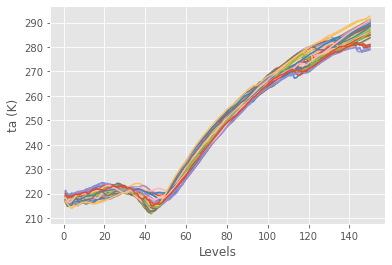

In [38]:
X = df_x_train.filter(like="ta")   #df_x_train [f"{key}_{i}" for i in range(150)]
wl = np.arange(1, 151, 1)

with plt.style.context('ggplot'):
    plt.plot(wl, X[:50].T)  #only for showing 50 points
    plt.xlabel("Levels")
    plt.ylabel("ta (K)")

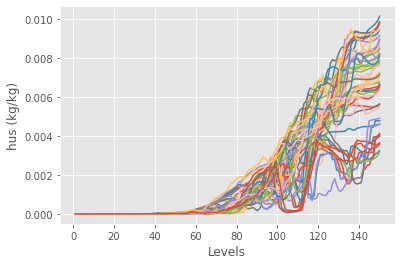

In [39]:
X = df_x_train.filter(like="hus")   #df_x_train [f"{key}_{i}" for i in range(150)]
wl = np.arange(1, 151, 1)

with plt.style.context('ggplot'):
    plt.plot(wl, X[:50].T)  #only for showing 50 points
    plt.xlabel("Levels")
    plt.ylabel("hus (kg/kg)")

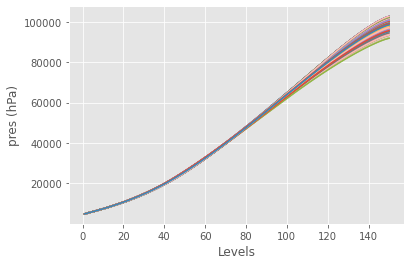

In [13]:
with plt.style.context('ggplot'):
    plt.plot(wl, X[247726:247826].T)  #only for showing 50 points
    plt.xlabel("Levels")
    plt.ylabel("pres (hPa)")

In [14]:
np.shape(X[:2].T)

(150, 2)

In [15]:
X2 = savgol_filter(X, 17, polyorder=2, deriv=2)

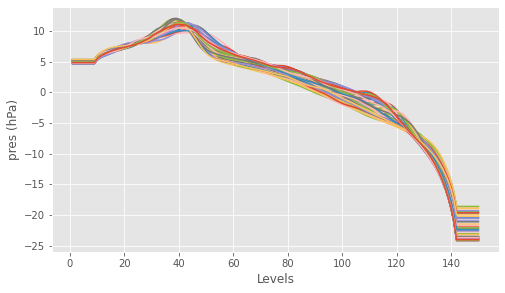

In [16]:
# plot and see
plt.figure(figsize=(8, 4.5))
with plt.style.context('ggplot'):
    plt.plot(wl, X2[:50].T)
    plt.xlabel("Levels")
    plt.ylabel("pres (hPa)")
    plt.show()

In [9]:
def optimise_pls_cv(X, y, n_comp):
    # Define PLS object
    pls = PLSRegression(n_components=n_comp)

    # Cross-validation
    y_cv = cross_val_predict(pls, X, y, cv=10)

    # Calculate scores
    r2 = r2_score(y, y_cv)
    mse = mean_squared_error(y, y_cv)
    rpd = y.std()/np.sqrt(mse)
    
    return (y_cv, r2, mse, rpd)

In [28]:
# test with 40 components
r2s = []
mses = []
rpds = []
xticks = np.arange(1, 40)
for n_comp in xticks:
    y_cv, r2, mse, rpd = optimise_pls_cv(X2, y, n_comp) #aca mejor tomar X probar luego
    r2s.append(r2)
    mses.append(mse)
    rpds.append(rpd)

In [29]:
# Plot the mses
def plot_metrics(vals, ylabel, objective):
    with plt.style.context('ggplot'):
        plt.plot(xticks, np.array(vals), '-v', color='blue', mfc='blue')
        if objective=='min':
            idx = np.argmin(vals)
        else:
            idx = np.argmax(vals)
        plt.plot(xticks[idx], np.array(vals)[idx], 'P', ms=10, mfc='red')

        plt.xlabel('Number of PLS components')
        plt.xticks = xticks
        plt.ylabel(ylabel)
        plt.title('PLS')

    plt.show()


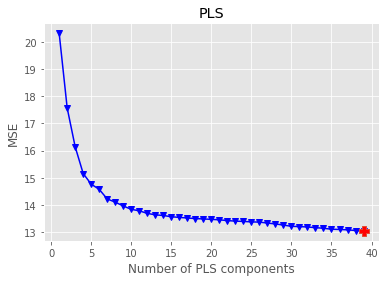

In [30]:
plot_metrics(mses, 'MSE', 'min')

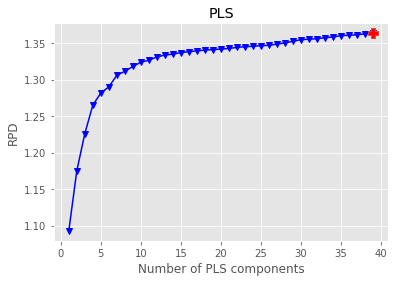

In [31]:
plot_metrics(rpds, 'RPD', 'max')

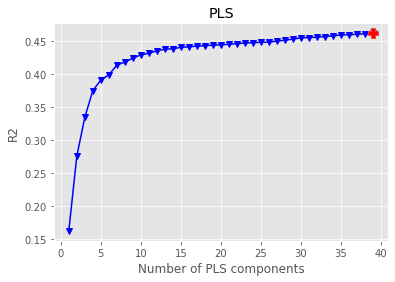

In [32]:
plot_metrics(r2s, 'R2', 'max')

### with only x 

In [ ]:
try to apply first log to it .... and maybe aplly other ML 

In [20]:
# test with 40 components
r2s = []
mses = []
rpds = []
xticks = np.arange(1, 45)
for n_comp in xticks:
    y_cv, r2, mse, rpd = optimise_pls_cv(X, y, n_comp) #aca mejor tomar X probar luego
    r2s.append(r2)
    mses.append(mse)
    rpds.append(rpd)

In [21]:
# Plot the mses
def plot_metrics(vals, ylabel, objective):
    with plt.style.context('ggplot'):
        plt.plot(xticks, np.array(vals), '-v', color='blue', mfc='blue')
        if objective=='min':
            idx = np.argmin(vals)
        else:
            idx = np.argmax(vals)
        plt.plot(xticks[idx], np.array(vals)[idx], 'P', ms=10, mfc='red')

        plt.xlabel('Number of PLS components')
        plt.xticks = xticks
        plt.ylabel(ylabel)
        plt.title('PLS')

    plt.show()

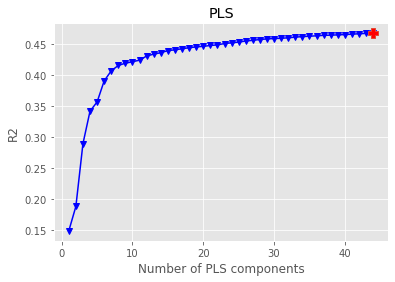

In [22]:
plot_metrics(r2s, 'R2', 'max')

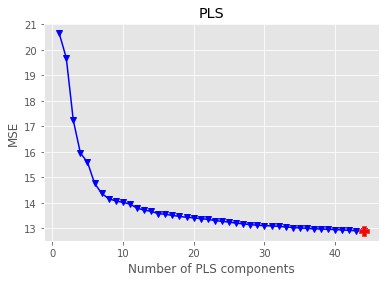

In [23]:
plot_metrics(mses, 'MSE', 'min')

### decrease all the variables 3D 


In [16]:
y = training_df_y_train["PCA_0"]

In [10]:
X = df_x_train.drop(columns =["lwp","Nd_max"]) 
X.head(1)

,pres_0,pres_1,pres_2,pres_3,pres_4,pres_5,pres_6,pres_7,pres_8,pres_9,...,hus_140,hus_141,hus_142,hus_143,hus_144,hus_145,hus_146,hus_147,hus_148,hus_149
276457,4942.9,5225.0,5492.5,5759.1,6027.5,6299.0,6574.3,6853.7,7137.7,7427.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
scaler = preprocessing.StandardScaler().fit(X)   
X = pd.DataFrame(scaler.transform(X), columns = X.columns) 
X.head(1)

,pres_0,pres_1,pres_2,pres_3,pres_4,pres_5,pres_6,pres_7,pres_8,pres_9,...,hus_140,hus_141,hus_142,hus_143,hus_144,hus_145,hus_146,hus_147,hus_148,hus_149
0,-1.5,-1.4,-1.2,-1.1,-1.0,-0.9,-0.9,-0.9,-0.9,-1.0,...,-0.4,-0.5,-0.5,-0.6,-0.6,-0.7,-0.7,-0.7,-0.8,-0.8


In [ ]:
def optimise_pls_cv(X, y, n_comp):
    # Define PLS object
    pls = PLSRegression(n_components=n_comp)

    # Cross-validation
    y_cv = cross_val_predict(pls, X, y, cv=10)

    # Calculate scores
    r2 = r2_score(y, y_cv)
    mse = mean_squared_error(y, y_cv)
    rpd = y.std()/np.sqrt(mse)
    
    return (y_cv, r2, mse, rpd)

In [18]:
# test with 40 components
r2s = []
mses = []
rpds = []
xticks = np.arange(1, 30)
for n_comp in xticks:
    y_cv, r2, mse, rpd = optimise_pls_cv(X, y, n_comp) #aca mejor tomar X probar luego
    r2s.append(r2)
    mses.append(mse)
    rpds.append(rpd)
    

In [13]:
# Plot the mses
def plot_metrics(vals, ylabel, objective):
    with plt.style.context('ggplot'):
        plt.plot(xticks, np.array(vals), '-v', color='blue', mfc='blue')
        if objective=='min':
            idx = np.argmin(vals)
        else:
            idx = np.argmax(vals)
        plt.plot(xticks[idx], np.array(vals)[idx], 'P', ms=10, mfc='red')

        plt.xlabel('Number of PLS components')
        plt.xticks = xticks
        plt.ylabel(ylabel)
        plt.title('PLS')

    plt.show()

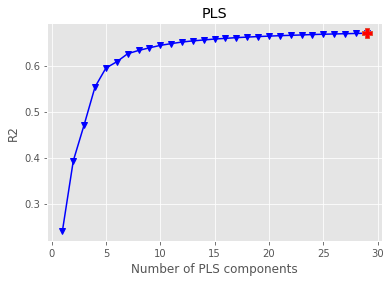

In [20]:
plot_metrics(r2s, 'R2', 'max')

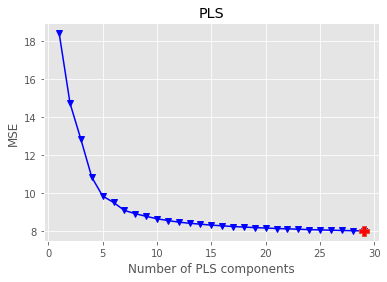

In [21]:
plot_metrics(mses, 'MSE', 'min')

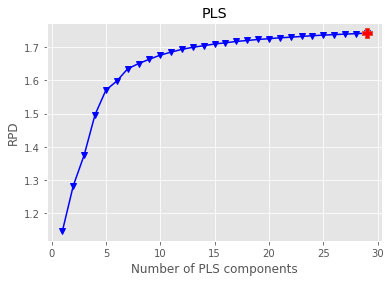

In [22]:
plot_metrics(rpds, 'RPD', 'max')

# with all variables

In [40]:
#
scaler = preprocessing.StandardScaler().fit(df_x_train)   
X = pd.DataFrame(scaler.transform(df_x_train), columns = df_x_train.columns) 
X.head(1)
X = X[:]
y = training_df_y_train["PCA_0"][:]

In [11]:
# test with 40 components
r2s = []
mses = []
rpds = []
xticks = np.arange(1, 100)
for n_comp in xticks:
    y_cv, r2, mse, rpd = optimise_pls_cv(X, y, n_comp) #aca mejor tomar X probar luego
    r2s.append(r2)
    mses.append(mse)
    rpds.append(rpd)

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:304: UserWarning: Y residual is constant at iteration 88
  warnings.warn(f"Y residual is constant at iteration {k}")
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:304: UserWarning: Y residual is constant at iteration 88
  warnings.warn(f"Y residual is constant at iteration {k}")
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:304: UserWarning: Y residual is constant at iteration 88
  warnings.warn(f"Y residual is constant at iteration {k}")
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:304: UserWarning: Y residual is constant at iteration 88
  warnings.warn(f"Y residual is constant at iteration {k}")
/sw/spack-levante/mambaforge-4.11.0-0-Linux-

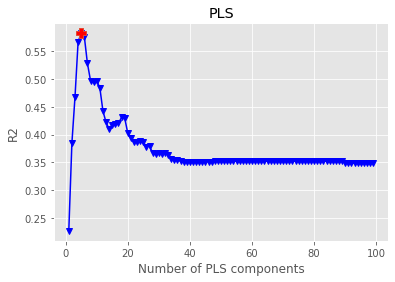

In [14]:
plot_metrics(r2s, 'R2', 'max')

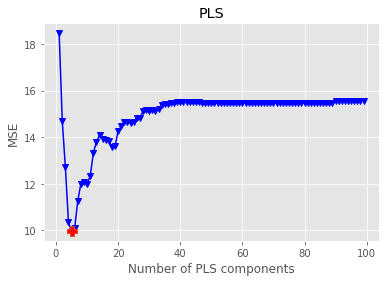

In [15]:
plot_metrics(mses, 'MSE', 'min')

# PCA

In [2]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import argparse
import pandas as pd
from eofs.xarray import Eof
from sklearn import preprocessing
from sklearn.decomposition import PCA

from lwp_nd import lwp_nd_input_ICON
from PCA_radiances import PCA_calculation, variance_sklearn_plot, dataframe_csv #, convert_3D

from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, check_scoring, mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
import os

In [3]:
########################## no used ################################33
def get_rmse_array(truth, pred):
    print(truth.shape, pred.shape)
    weights = np.cos(np.deg2rad(truth.lat))

    return np.sqrt(((truth - pred.reshape(-1, 96,144))**2).weighted(weights).mean(['lat', 'lon'])).data.mean()

########################## no used ################################33
def get_training_inputs(path_ICON):
    ds = xr.open_dataset(path_ICON).compute()
   
    p_2013 = ds.pres.values #/100 #convert to hPa
    T_2013 = ds.ta.values
    q_2013 = ds.hus.values
    max_cdnc_2013_cm = ds.Nd_max.values
    lwp_2013 = ds.lwp.values
    #lat = ds.lat
    #lon = ds.lot
    #height = ds.height

    # call pca, new to run it again and kmwasn but also adapt inputs array of inputs, array of outpus, usig of reference code of clibenc
    # train_files = [ "T09", "T12" ]
    # train_inputs_variables_1d = [ 'height','lat', 'lon']
    # train_inputs_variables_2d = [ "t2m", 'q2m', 'p_surf', 'u_surf', 'v_surf', 't_skin', 'h_surf', 'lat', 'lon', 'qnc', 'lwp']
    # train_inputs_variables_3d = [ "p", "t", "q", 'tca', 'lwc', 'iwc']
    
    train_inputs_variables_2D = { "Nd_max": Nd_max, "lwp": lwp}  # ['Nd_max', 'lwp'] #(lat, lon)
    train_inputs_variables_3D = { "pres": p_2013, "ta": T_2013, "hus":q_2013} #(height, lat, lon)
    
    ############ variables 2D ######################################
    df_train_inputs_variables_2D= pd.DataFrame({  #falta normalizar
    "Nd_max" : ds.Nd_max.values.flatten(),
    "LWP" : ds["lwp"].values.flatten() }) 

    print("============== 2D variables statistics ==================== ")
    print("LWP shape: {}".format(np.shape(ds["lwp"].values)))
    print(df_train_inputs_variables_2D.describe())#if i mask i will have nan instead of Nd<2 and LWP<o
    # print("LWP min: {}, max: {}".format(ds["lwp"].values.min(), np.max(ds["lwp"].values)))
    # print("Nd_max min: {}, max: {}".format(ds["Nd_max"].values.min(), np.max(ds["Nd_max"].values)))
    count_nan_in_df = pd.DataFrame(df_train_inputs_variables_2D).isnull().sum()
    print ("=========print NaNs: \n", count_nan_in_df)  #can i used 0 in the lwp and nd?
    # df = df.fillna(0) #there is not nan

    print("============== 3D variables statistics ==================== ")
    print("pres min: {}, max: {}, mean: {}".format(np.min(p_2013), np.max(p_2013), np.mean(p_2013)))
    print("ta min: {}, max: {}, mean: {}".format(ds["ta"].values.min(), np.max(ds["ta"].values),ds["ta"].values.mean()))
    print("hus min: {}, max: {}, mean: {}".format(ds["hus"].values.min(), np.max(ds["hus"].values), ds["hus"].values.mean()))

    return df_train_inputs_variables_2D, train_inputs_variables_2D, train_inputs_variables_3D 

########################## no used ################################33

 


def test_random_forest(train_x, train_y, test_x, test_y):
    # rf_model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
    #                   max_depth=None, max_features='auto', max_leaf_nodes=None,
    #                   max_samples=None, min_impurity_decrease=0.0,
    #                   min_impurity_split=None, min_samples_leaf=1,
    #                   min_samples_split=2, min_weight_fraction_leaf=0.0,
    #                   n_estimators=100, n_jobs=None, oob_score=False,
    #                   random_state=None, verbose=0, warm_start=False)
    # rf_model = RandomForestRegressor(bootstrap=False, random_state = 0, max_features='auto', n_estimators=200, min_samples_split= 100, min_samples_leaf=4,max_depth=1,  criterion='mse')
                                     
    rf_model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      #min_impurity_split=None, min_samples_leaf=1,
                      min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)                              
        
# rf_model = RandomForestRegressor( random_state=0, bootstrap=False, max_features='auto', **{'n_estimators': 200, 'min_samples_split': 100, 'min_samples_leaf': 4,  'max_depth': 1})
    
    rf_pcs = rf_model.fit(train_x, train_y)
    

        
    return rf_pcs

def read_data_refl_emiss_rttov_old(rttov_path_rad, rttov_path_refl_emmis):
    '''
    input: path of the radiances and reflectances
    output: refl_emmiss CHxHxW  
    '''
    rttov_ds_rad = xr.open_dataset(rttov_path_rad).compute()  # write read rttov in a function
    rttov_ds_refl_emmi = xr.open_dataset(rttov_path_refl_emmis).compute()    
    
    
    rttov_variable = np.zeros((np.shape(rttov_ds_rad['Y'].values)))
    # print("****************variables shape ", np.shape(rttov_ds_refl_emmi['bt_refl_total'].values), np.shape(rttov_variable), np.shape(rttov_ds_rad['Y'].values))

    rttov_variable[:19] = rttov_ds_refl_emmi['bt_refl_total'][:19] #refl 1-19, 26 rad 20-25 and 27-36
    rttov_variable[19:25] = rttov_ds_rad['Y'][19:25]
    rttov_variable[25] = rttov_ds_refl_emmi['bt_refl_total'][19] #solo tengo en este archivo 1-19,26 luego tengo q hacer todo esto en un solo file
    rttov_variable[26:36] = rttov_ds_rad['Y'][26:36]

    print("===================================== Training output ====================================== ")

    print("****************variables shape training_output", np.shape(rttov_variable))
    
    rttov_ds_rad.close()
    rttov_ds_refl_emmi.close()
        
    #rttov_bands =rttov_ds_rad['chan'].values
    # print('rttov_variable',np.shape(rttov_variable))
    
    #output then I dont neet to cut   !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    rttov_variable_ds = xr.DataArray( rttov_variable[:,9:,], dims=['chan','lat','lon'], coords= [rttov_ds_rad.chan.data, rttov_ds_refl_emmi.lat.data[9:], rttov_ds_refl_emmi.lon.data ])
        

    return  rttov_variable_ds

########################## no used ################################33
### the next should be the last version 
def read_data_refl_emiss_rttov(path_rttov_test):
    '''
    
    output: refl_emmiss #(HxWxCH)
    '''
    rttov_ds_refl_emmi = xr.open_dataset(path_rttov_test).compute()
    rttov_variable = np.zeros((np.shape(rttov_ds_refl_emmi['radiances_total'].values)))
    
    
    print("****************variables shape ", np.shape(rttov_ds_refl_emmi['bt_refl_total'].values), np.shape(rttov_variable), np.shape(rttov_ds_refl_emmi['radiances_total'].values))
    

            
    rttov_variable[:19] = rttov_ds_refl_emmi['bt_refl_total'][:19] #refl 1-19, 26 rad 20-25 and 27-36
    rttov_variable[19:25] = rttov_ds_refl_emmi['radiances_total'][19:25]
    rttov_variable[25] = rttov_ds_refl_emmi['bt_refl_total'][25] #solo tengo en este archivo 1-19,26 luego tengo q hacer todo esto en un solo file
    rttov_variable[26:36] = rttov_ds_refl_emmi['radiances_total'][26:36]  

    print('rttov_variable',np.shape(rttov_variable))
    
    rttov_ds_refl_emmi.close()
        
    #rttov_bands =rttov_ds_rad['chan'].values
    # print('rttov_variable',np.shape(rttov_variable))
    refl_emmiss =  rttov_variable[:,9:,] #.transpose(1,2,0) #output then I dont neet to cut ######################
    
    rttov_variable_ds = xr.DataArray(rttov_variable, dims=['chan','lat','lon'], coords= [rttov_ds_refl_emmi.chan.data, rttov_ds_refl_emmi.lat.data, rttov_ds_refl_emmi.lon.data ])
        

    return  rttov_variable_ds

    #return  refl_emmiss, rttov_bands

    
def plot_target_prediction(target, prediction, path_output, name_plot):
    n_img = len(target)
    fig = plt.figure(figsize=(5 * n_img, 5 * 2 ))  #WxH
    
    fig.suptitle("Comparation between target and prediction")

    for i in range(n_img):

        # Emulator
        axes = plt.subplot(2,n_img, i + 1)
        ctr = axes.pcolormesh(prediction[i])
        # ctr = axes.pcolormesh(predicted_input)
        axes.set_title(f"Prediction PC_{i}")
        plt.colorbar(ctr)
        
        # Target
        axes0 = plt.subplot(2,n_img, i + 1 + n_img)
        ctr = axes0.pcolormesh(target[i])
        # ctr = axes0.pcolormesh(target)
        axes0.set_title(f"Target PC_{i}")
        plt.colorbar(ctr)
    plt.tight_layout()
        
        
    figure_name = '{}/{}.png'.format(path_output, name_plot) #aca pasarr con todo path
                   
    fig.savefig(figure_name) 
    plt.close()   
    
########################## no used ################################33

def permutation_test(X_test, pr_truth, rf_pr):
    #%%time
    pr_result = permutation_importance(
        # rf_pr.model.model, X_test, pr_truth, n_repeats=10, random_state=42, n_jobs=1, scoring=make_scorer(get_rmse_array))
        rf_pr.model.model, X_test, pr_truth, n_repeats=10, random_state=42, n_jobs=1)

    importances = rf_pr.model.model.feature_importances_
    feature_names = list(X_test.columns)
    
    std = np.std([tree.feature_importances_ for tree in rf_pr.model.model.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=feature_names)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("PC0")

    ax.set_ylabel("Feature importances")
    fig.tight_layout()
            
    figure_name = '{}/Feature importances.png'.format(path_output) #aca pasarr con todo path
                   
    fig.savefig(figure_name) 
    plt.close()   
  
   
    
def old_scaler_PCA_input(train_inputs_2D, train_inputs_3D, path_output):
    '''
    input: dataframe input with 2D and 3D
    output: x_train_df dataframe with the variable 2D and 3D PCAs
    '''
    
    n_pca_variables_3D = { "pres": 5, "ta": 10, "hus":24} #(height, lat, lon)
        
#     scaler_2D = preprocessing.StandardScaler()# Fit on training set only.
#     scaler_2D.fit(df_train_inputs_variables_2D)
    scaler_2D = preprocessing.StandardScaler().fit(df_train_inputs_variables_2D)

        
    training_input_variables_df = pd.DataFrame(scaler_2D.transform(df_train_inputs_variables_2D), columns = ["Nd_max", "lwp"]) 

    # Get PC of the variables 3D
    scaler_3D = []
    pca_3D = []

    for key, var in train_inputs_variables_3D.items():  
        var = var.values.transpose(1,2,0) #lat,lot,heigh
        var_df = pd.DataFrame(var.reshape(-1, var.shape[2]))
        var_df.columns = [f"{key}_{i}" for i in range(var.shape[2])]
        # scaler = preprocessing.StandardScaler().fit(var_df) 
        scaler = preprocessing.StandardScaler()# Fit on training set only. 
        scaler.fit(var_df)  #antes esto estaba despues 
        #norm = preprocessing.Normalizer().fit(xtrain)
        scaler_3D.append(scaler)
        
        var_scaled = scaler.transform(var_df)
        
        
        n_pca = n_pca_variables_3D[key] #150
        name_plot= "{}_Explained_variance_{}_variable".format(n_pca, key)
        print("============== Variable: {}  ========================================".format(key))

        X_pca, pca = PCA_calculation(var_scaled, name_plot,n_pca, path_output)
        pca_3D.append(pca)
        
        # print( 'Original shape: {}'.format(str(PC.shape)))
        print( 'Original shape: {}'.format(str(var.shape)))
        print( 'Reduced shape: {}'.format(str(X_pca.shape)))
        principalDf = pd.DataFrame(data = X_pca
             , columns = [f"{key}_PCA_{i}" for i in range(n_pca)])
        training_input_variables_df=pd.concat([training_input_variables_df, principalDf], axis=1)



        # training_input_variables_df=pd.concat([training_input_variables_df, var_df], axis=1)



    # for key, var in train_inputs_variables_3D.items():  
    #     var = var.transpose(1,2,0)
    #     var_df = pd.DataFrame(var.reshape(-1, var.shape[2]))
    #     var_df.columns = [f"{key}_{i}" for i in range(var.shape[2])]
    #     training_input_variables_df=pd.concat([training_input_variables_df, var_df], axis=1)


    print("================ dataframe =============================")
    training_input_variables_df.describe().to_csv(path_output + "/inputs_after_PCA_StandardScaler.csv")    
    # count_nan 
    count_nan_in_df = training_input_variables_df.isnull().sum()
    print("================ values of Nan in training_input_variables_df =====================")

    print (count_nan_in_df)  #can i used 0 in the lwp and nd?
    
    #X_train_np = np.array([X_train_reshaped['pres'].data, X_train_reshaped['ta'].data, X_train_reshaped['hus'].data, X_train_reshaped['qnc'].data])

    # pd.set_option('display.float_format', lambda x: '%.1f' % x)
    # df.columns= colum
    

    return training_input_variables_df, scaler_2D, scaler_3D, pca_3D, n_pca_variables_3D


def get_split_data_xarray(path_ICON, rttov_path_rad, rttov_path_refl_emmis, path_output):
    '''
    Input: path of the X and Y. X = ICON-LES, Y = RTTOV-radiances/reflectances
    Output: xarray.DataArray  chan: 36, lat: 637, lon: 589
    
    dataframes 
    x_train_2D, x_train_3D (height, lat, lon) = ICON-LES lat < 53.01
    x_test_2D, x_test_3D (height, lat, lon) =  ICON-LES lat > 53.01
    y_train, y_test (chan: 36, lat, lon)  = radiances/reflectances 
    
    df_y_train: dataframe  row = H*W, colum = CH  
    '''
    ds = xr.open_dataset(path_ICON).compute()
    
    #================================= X ========================================

    ds_x_train = ds.sel(lat=slice(0,53))  # I am keeping the higher area
    ds_x_test = ds.sel(lat=slice(53.01,60))
    
    ds.close()
    
    x_train_2D = { "Nd_max": ds_x_train.Nd_max.values, "lwp": ds_x_train.lwp.values}  
    
        
    x_train_3D = { "pres": ds_x_train.pres.values, "ta": ds_x_train.ta.values, "hus": ds_x_train.hus.values}
    
 
    x_test_2D = { "Nd_max": ds_x_test.Nd_max.values, "lwp": ds_x_test.lwp.values}  
    x_test_3D = { "pres": ds_x_test.pres.values, "ta": ds_x_test.ta.values, "hus": ds_x_test.hus.values}
    
    #=============================Dataframe X  ====================================    
    df_x_train = pd.DataFrame()
    df_x_test = pd.DataFrame()
    
    for key, var in x_train_2D.items():  
        df = pd.DataFrame(data = var.flatten()
             , columns =  [key])
        df_x_train = pd.concat([df_x_train, df], axis=1)   
    for key, var in x_train_3D.items():  
        var = var.transpose(1,2,0) #lat,lot,heigh
        var_df = pd.DataFrame(var.reshape(-1, var.shape[2]))
        var_df.columns = [f"{key}_{i}" for i in range(var.shape[2])]
        df_x_train=pd.concat([df_x_train, var_df], axis=1)

    
    for key, var in x_test_2D.items():  
        df = pd.DataFrame(data = var.flatten()
             , columns = [key])
        df_x_test = pd.concat([df_x_test, df], axis=1)   
    for key, var in x_test_3D.items():  
        var = var.transpose(1,2,0) #lat,lot,heigh
        var_df = pd.DataFrame(var.reshape(-1, var.shape[2]))
        var_df.columns = [f"{key}_{i}" for i in range(var.shape[2])]
        df_x_test=pd.concat([df_x_test, var_df], axis=1)
        
    #================================= Y ========================================
    rttov_variable_ds = read_data_refl_emiss_rttov_old(rttov_path_rad, rttov_path_refl_emmis)
    y_train = rttov_variable_ds.sel(lat=slice(0,53))
    y_test = rttov_variable_ds.sel(lat=slice(53.01, 60))  
    
    # shape_y_test_3D = np.shape(y_test)
    lat_test_ds = y_test.lat
    lon_test_ds = y_test.lon

    
    ###############################Dataframe Y_data##################################
    name_file = 'refl_emiss_statistics'
    df_y = dataframe_csv(variable = rttov_variable_ds.transpose('lat', 'lon', 'chan').values, 
                  column = y_train.chan.values,  
                  path_output = path_output, 
                  name_file = name_file)
           
    ############## convert img_rttov: because the input for the dataframe_csv need to be HxWxCH I use transpose ##########################
    name_file = 'refl_emiss_statistics_train'
    df_y_train = dataframe_csv(variable = y_train.transpose('lat', 'lon', 'chan').values, 
                  column = y_train.chan.values,  
                  path_output = path_output, 
                  name_file = name_file)
    
    name_file = 'refl_emiss_statistics_test'
    df_y_test = dataframe_csv(variable = y_test.transpose('lat', 'lon', 'chan').values, 
                  column = y_train.chan.values, 
                  path_output = path_output, 
                  name_file = name_file)
    ###################################################################################
        
    return x_train_2D, x_train_3D, x_test_2D, x_test_3D, y_train, y_test,  df_x_train, df_x_test, df_y_train, df_y_test, lat_test_ds, lon_test_ds

  
def scaler_PCA_input(df_x_train, path_output):
    '''
    input: dataframe input with 2D and 3D
    output: x_train_df dataframe with the variable 2D and 3D PCAs
    '''
    variables_2D = { "Nd_max", "lwp"}  
    n_pca_variables_3D = { "pres": 5, "ta": 10, "hus":24} #(height, lat, lon)
    # scaler_variables = { "Nd_max", "lwp", "pres", "ta", "hus"}
    training_df_x_train = pd.DataFrame()

    scaler = preprocessing.StandardScaler().fit(df_x_train)   
    df = pd.DataFrame(scaler.transform(df_x_train), columns = df_x_train.columns) 

    pca_3D = {}
    
    for key in variables_2D: 
        training_df_x_train=pd.concat([training_df_x_train, df[key]], axis=1)

    for key, var in n_pca_variables_3D.items():  
        var_scaled = df.filter(like=key)                 
        n_pca = var 
        name_plot= "{}_Explained_variance_{}_variable".format(n_pca, key)
        print("============== Variable: {}  ========================================".format(key))
        X_pca, pca = PCA_calculation(var_scaled.to_numpy(), name_plot,n_pca, path_output)
        #pca_3D.append(pca)
        pca_3D[key] = pca

        # print( 'Original shape: {}'.format(str(PC.shape)))
        print( 'Original shape: {}'.format(str(var_scaled.shape)))
        print( 'Reduced shape: {}'.format(str(X_pca.shape)))
        principalDf = pd.DataFrame(data = X_pca
             , columns = [f"{key}_PCA_{i}" for i in range(n_pca)])
        training_df_x_train = pd.concat([training_df_x_train, principalDf], axis=1)

    print("================ dataframe all after PCA=============================")
    training_df_x_train.describe().to_csv(path_output + "/inputs_after_PCA_StandardScaler.csv")    
    # count_nan 
    count_nan_in_df = training_df_x_train.isnull().sum()
    print("================ values of Nan in training_input_variables_df =====================")
    print (count_nan_in_df)  #can i used 0 in the lwp and nd?


    return training_df_x_train, scaler, pca_3D, n_pca_variables_3D


def PCA_read_input_target(df_y_train, path_output):
    '''
    PC_output (latxlon, number_pcs)
    '''
    scaler_y = preprocessing.StandardScaler().fit(df_y_train)  #Standardize features by removing the mean and scaling to unit variance
    X_scaled = scaler_y.transform(df_y_train)
    ###### analysis  PCA###########################
    name_plot= "Explained_variance_refl_emiss"
    n_pca = 6 
    n_bands = len(df_y_train.columns) # rttov_bands) #2 #test JQ     
    X_reduced_output, pca_y = PCA_calculation(X_scaled, name_plot, n_pca, path_output) #PC_output_all

    principalDf = pd.DataFrame(data = X_reduced_output
             , columns = [f"PCA_{i}" for i in range(np.shape(X_reduced_output)[1])])
        
        
    return scaler_y, principalDf, pca_y

##################### 
def get_test_input(path_output, df_x_test, scaler, pca_3D, n_pca_variables_3D):
    '''
    PC_output (latxlon, number_pcs)
    '''
    testing_df_x_test = pd.DataFrame()
    
    variables_2D = { "Nd_max", "lwp"}  
    # variables_3D = { "pres", "ta", "hus"} 

        
    df = pd.DataFrame(scaler.transform(df_x_test), columns = df_x_test.columns) 
    
    for key in variables_2D: 
        testing_df_x_test=pd.concat([testing_df_x_test, df[key]], axis=1)

        
    for key in n_pca_variables_3D:  
        var_scaled = df.filter(like=key)   
        principalDf = pd.DataFrame(data = pca_3D[key] .transform(var_scaled.to_numpy()) #pca_3D [i] i de 1 
             , columns = [f"{key}_PCA_{i}" for i in range(n_pca_variables_3D[key])])
        testing_df_x_test = pd.concat([testing_df_x_test, principalDf], axis=1)
        
    return testing_df_x_test


def get_test_output(df, path_output, scaler, pca):
    # y_test, rttov_bands = read_data_refl_emiss_rttov(path_rttov_test)
    # ###### flat ###########################
    # name_file = 'refl_emiss_test'
    # df = dataframe_csv(variable = y_test, colum = rttov_bands, path_output = path_output, name_file = name_file)
    test_df= scaler.transform(df)
    test_df = pca.transform(test_df)
    
    return test_df

    

In [4]:
x_train_2D, x_train_3D, x_test_2D, x_test_3D, y_train, y_test,  df_x_train, df_x_test, df_y_train, df_y_test, lat_test_ds, lon_test_ds = get_split_data_xarray(path_ICON, rttov_path_rad, rttov_path_refl_emmis, path_output)


===================================== Training output ====================================== 
****************variables shape training_output (36, 637, 589)
dataframe (36,) (628, 589, 36)
(369892, 36)
In band 1.0 values NaN: 0
In band 2.0 values NaN: 0
In band 3.0 values NaN: 0
In band 4.0 values NaN: 0
In band 5.0 values NaN: 0
In band 6.0 values NaN: 0
In band 7.0 values NaN: 0
In band 8.0 values NaN: 0
In band 9.0 values NaN: 0
In band 10.0 values NaN: 0
In band 11.0 values NaN: 0
In band 12.0 values NaN: 0
In band 13.0 values NaN: 0
In band 14.0 values NaN: 0
In band 15.0 values NaN: 0
In band 16.0 values NaN: 0
In band 17.0 values NaN: 0
In band 18.0 values NaN: 0
In band 19.0 values NaN: 0
In band 20.0 values NaN: 0
In band 21.0 values NaN: 0
In band 22.0 values NaN: 0
In band 23.0 values NaN: 0
In band 24.0 values NaN: 0
In band 25.0 values NaN: 0
In band 26.0 values NaN: 0
In band 27.0 values NaN: 0
In band 28.0 values NaN: 0
In band 29.0 values NaN: 0
In band 30.0 values NaN: 

In [5]:

    
    ### PCA of the input and scaler
    training_df_x_train, scaler_x, pca_3D, n_pca_variables_3D = scaler_PCA_input(df_x_train, path_output)

    
    ### PCA of the output and scaler
    scaler_y, training_df_y_train, pca_y = PCA_read_input_target(df_y_train, path_output)

    
    ##### scale and PCA Test input
    testing_df_x_test = get_test_input(path_output, df_x_test, scaler_x, pca_3D, n_pca_variables_3D)
    
    ### scale and PCA Test output

    testing_df_y_test = get_test_output(df_y_test, path_output, scaler_y, pca_y)


============== Variable: pres  ========================================
Eigenvalues:

 [1.000e+02 4.773e+01 1.828e+00 1.416e-01 9.404e-02 6.335e-02 3.412e-02
 2.198e-02 1.571e-02 1.378e-02 1.174e-02 7.824e-03 4.903e-03 4.368e-03
 3.309e-03 2.581e-03 1.630e-03 1.467e-03 1.094e-03 9.280e-04 7.295e-04
 5.327e-04 4.941e-04 3.523e-04 2.642e-04 2.234e-04 1.919e-04 1.416e-04
 1.317e-04 1.115e-04 8.966e-05 7.941e-05 6.234e-05 4.827e-05 4.412e-05
 3.336e-05 3.196e-05 2.602e-05 2.309e-05 2.125e-05 1.845e-05 1.529e-05
 1.290e-05 1.225e-05 1.132e-05 9.418e-06 8.126e-06 6.711e-06 5.760e-06
 4.972e-06 4.753e-06 4.225e-06 3.935e-06 3.458e-06 2.950e-06 2.627e-06
 2.390e-06 2.180e-06 1.947e-06 1.673e-06 1.503e-06 1.298e-06 1.206e-06
 1.112e-06 1.027e-06 8.672e-07 8.042e-07 7.110e-07 6.874e-07 6.093e-07
 5.307e-07 4.965e-07 4.558e-07 3.977e-07 3.719e-07 3.426e-07 3.052e-07
 2.653e-07 2.495e-07 2.280e-07 2.157e-07 1.969e-07 1.790e-07 1.579e-07
 1.468e-07 1.393e-07 1.335e-07 1.118e-07 1.038e-07 9.304e-08 

In [6]:
    x_train = training_df_x_train
    x_test = testing_df_x_test
    y_train = training_df_y_train
    y_test = testing_df_y_test

In [11]:
#     rf_pcs = test_random_forest(train_x = training_df_x_train,
#                                           train_y = training_df_y_train, 
#                                           test_x = testing_df_x_test, 
#                                           test_y = testing_df_y_test)
        
#     x_train = training_df_x_train
#     x_test = testing_df_x_test
#     y_train = training_df_y_train
#     y_test = testing_df_y_test
# ###################################################################################################

#     # rf_pcs = test_random_forest(train_x = train_x_df,
#     #                                           train_y = train_y_df, 
#     #                                           test_x = test_x_df, 
#     #                                           test_y = test_y)


#     # rf_pcs = test_random_forest(train_x = x_train,
#     #                                       train_y = y_train, 
#     #                                       test_x = x_test, 
#     #                                       test_y = y_test)

    
    
#     gt =  y_train 
#     pred = rf_pcs.predict(x_train)
#     print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(gt, pred))
#     print('Mean Squared Error (MSE):', metrics.mean_squared_error(gt, pred))
#     print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(gt, pred)))
#     mape = np.mean(np.abs((gt - pred) / np.abs(gt)))
#     print('Mean Absolute Percentage Error (MAPE): \n', round(mape * 100, 2))
#     print('Accuracy: \n', round(100*(1 - mape), 2))

#     gt =  y_test 
#     pred = rf_pcs.predict(x_test)
#     print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(gt, pred))
#     print('Mean Squared Error (MSE):', metrics.mean_squared_error(gt, pred))
#     print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(gt, pred)))
#     mape = np.mean(np.abs((gt - pred) / np.abs(gt)))
#     print('Mean Absolute Percentage Error (MAPE): \n', round(mape * 100, 2))
#     print('Accuracy: \n', round(100*(1 - mape), 2))

#     score = rf_pcs.score(x_train, y_train)
#     print('score in training:', score)  
#     score = rf_pcs.score(x_test, y_test)
#     print('score in testing:', score)

============== Variable: pres  ========================================
Eigenvalues:

 [1.000e+02 4.773e+01 1.828e+00 1.416e-01 9.404e-02 6.335e-02 3.412e-02
 2.198e-02 1.571e-02 1.378e-02 1.174e-02 7.824e-03 4.903e-03 4.368e-03
 3.309e-03 2.581e-03 1.630e-03 1.467e-03 1.094e-03 9.280e-04 7.295e-04
 5.327e-04 4.941e-04 3.523e-04 2.642e-04 2.234e-04 1.919e-04 1.416e-04
 1.317e-04 1.115e-04 8.966e-05 7.941e-05 6.234e-05 4.827e-05 4.412e-05
 3.336e-05 3.196e-05 2.602e-05 2.309e-05 2.125e-05 1.845e-05 1.529e-05
 1.290e-05 1.225e-05 1.132e-05 9.418e-06 8.126e-06 6.711e-06 5.760e-06
 4.972e-06 4.753e-06 4.225e-06 3.935e-06 3.458e-06 2.950e-06 2.627e-06
 2.390e-06 2.180e-06 1.947e-06 1.673e-06 1.503e-06 1.298e-06 1.206e-06
 1.112e-06 1.027e-06 8.672e-07 8.042e-07 7.110e-07 6.874e-07 6.093e-07
 5.307e-07 4.965e-07 4.558e-07 3.977e-07 3.719e-07 3.426e-07 3.052e-07
 2.653e-07 2.495e-07 2.280e-07 2.157e-07 1.969e-07 1.790e-07 1.579e-07
 1.468e-07 1.393e-07 1.335e-07 1.118e-07 1.038e-07 9.304e-08 

In [41]:
import pickle

In [8]:
import joblib

In [ ]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

# some time later...

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

In [15]:
# joblib.dump(rf_pcs, "./random_forest.joblib")

['./random_forest.joblib']

In [16]:
# joblib.dump(rf_pcs, "RF_compressed.joblib", compress=3)  # compression is ON!

['RF_compressed.joblib']

In [9]:
import joblib
loaded_rf = joblib.load("./RF_compressed.joblib")

In [7]:
import joblib
loaded_rf = joblib.load("./random_forest.joblib")

In [10]:
    score = loaded_rf.score(x_train, y_train)
    print('score in training:', score)  

score in training: 0.9759944480291646


In [11]:
    score = loaded_rf.score(x_test, y_test)
    print('score in testing:', score)

score in testing: 0.47688389413544535


In [11]:
df_x_train.describe()

,Nd_max,lwp,pres_0,pres_1,pres_2,pres_3,pres_4,pres_5,pres_6,pres_7,...,hus_140,hus_141,hus_142,hus_143,hus_144,hus_145,hus_146,hus_147,hus_148,hus_149
count,289788.0,289788.0,289788.0,289788.0,289788.0,289788.0,289788.0,289788.0,289788.0,289788.0,...,289788.0,289788.0,289788.0,289788.0,289788.0,289788.0,289788.0,289788.0,289788.0,289788.0
mean,110.8,61.1,4957.3,5241.7,5510.8,5778.8,6048.9,6322.4,6600.2,6882.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,170.6,129.8,6.7,8.0,9.4,10.9,12.6,14.5,16.5,18.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,4941.5,5222.3,5487.4,5751.1,6016.8,6285.4,6558.2,6835.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,4952.4,5236.1,5504.4,5771.6,6040.5,6312.7,6589.1,6870.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,13.5,2.4,4957.5,5241.7,5511.0,5779.1,6049.2,6322.7,6600.4,6882.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,171.2,66.7,4962.9,5247.8,5517.7,5786.7,6057.7,6332.5,6611.8,6896.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,3446.8,4600.8,4976.5,5263.4,5536.2,5809.0,6084.4,6362.8,6645.2,6932.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
df_x_test.describe()

,Nd_max,lwp,pres_0,pres_1,pres_2,pres_3,pres_4,pres_5,pres_6,pres_7,...,hus_140,hus_141,hus_142,hus_143,hus_144,hus_145,hus_146,hus_147,hus_148,hus_149
count,80104.0,80104.0,80104.0,80104.0,80104.0,80104.0,80104.0,80104.0,80104.0,80104.0,...,80104.0,80104.0,80104.0,80104.0,80104.0,80104.0,80104.0,80104.0,80104.0,80104.0
mean,128.8,65.9,4945.6,5226.7,5492.6,5757.2,6023.6,6293.4,6567.3,6846.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,168.1,112.0,4.6,5.8,6.8,7.8,8.8,9.9,11.1,12.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,4933.4,5212.6,5476.9,5739.2,6002.9,6269.6,6540.4,6815.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,4942.6,5222.9,5488.0,5751.9,6017.6,6286.4,6559.4,6837.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,24.9,2.9,4945.1,5226.4,5492.3,5756.9,6023.3,6293.1,6567.1,6845.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,245.0,88.4,4948.8,5230.8,5496.9,5761.8,6028.7,6299.1,6574.0,6854.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1334.6,1290.2,4958.1,5241.7,5511.3,5779.5,6049.6,6323.4,6600.8,6882.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
training_df_x_train.describe()

,Nd_max,lwp,pres_PCA_0,pres_PCA_1,pres_PCA_2,pres_PCA_3,pres_PCA_4,ta_PCA_0,ta_PCA_1,ta_PCA_2,...,hus_PCA_14,hus_PCA_15,hus_PCA_16,hus_PCA_17,hus_PCA_18,hus_PCA_19,hus_PCA_20,hus_PCA_21,hus_PCA_22,hus_PCA_23
count,289788.0,289788.0,289788.0,289788.0,289788.0,289788.0,289788.0,289788.0,289788.0,289788.0,...,289788.0,289788.0,289788.0,289788.0,289788.0,289788.0,289788.0,289788.0,289788.0,289788.0
mean,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,...,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0
std,1.0,1.0,10.0,6.9,1.4,0.4,0.3,9.6,5.2,2.7,...,1.2,1.1,1.0,1.0,1.0,0.9,0.9,0.8,0.8,0.8
min,-0.6,-0.5,-19.1,-19.7,-4.9,-2.1,-0.9,-20.7,-12.7,-8.2,...,-5.0,-5.6,-4.7,-4.3,-3.8,-4.6,-3.4,-4.3,-4.2,-3.4
25%,-0.6,-0.5,-7.3,-5.1,-0.7,-0.2,-0.2,-8.0,-4.2,-2.3,...,-0.8,-0.7,-0.7,-0.7,-0.6,-0.6,-0.6,-0.5,-0.5,-0.5
50%,-0.6,-0.5,-1.0,0.6,0.1,0.0,-0.0,-0.2,-0.7,0.2,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0
75%,0.4,0.0,7.7,4.6,1.0,0.2,0.2,7.3,4.1,2.1,...,0.8,0.7,0.7,0.7,0.5,0.6,0.5,0.5,0.5,0.5
max,19.6,35.0,60.6,42.9,7.1,2.1,1.2,24.4,18.7,9.3,...,5.8,6.0,5.0,4.6,4.9,4.6,4.0,4.8,4.5,4.2


In [14]:
testing_df_x_test.describe()

,Nd_max,lwp,pres_PCA_0,pres_PCA_1,pres_PCA_2,pres_PCA_3,pres_PCA_4,ta_PCA_0,ta_PCA_1,ta_PCA_2,...,hus_PCA_14,hus_PCA_15,hus_PCA_16,hus_PCA_17,hus_PCA_18,hus_PCA_19,hus_PCA_20,hus_PCA_21,hus_PCA_22,hus_PCA_23
count,80104.0,80104.0,80104.0,80104.0,80104.0,80104.0,80104.0,80104.0,80104.0,80104.0,...,80104.0,80104.0,80104.0,80104.0,80104.0,80104.0,80104.0,80104.0,80104.0,80104.0
mean,0.1,0.0,-15.5,2.8,2.5,-0.1,-0.1,-13.6,10.7,-1.6,...,-0.7,-0.7,1.8,0.4,-0.2,-0.8,1.0,0.4,-0.1,-0.5
std,1.0,0.9,3.5,4.9,0.6,0.3,0.3,6.7,2.9,2.2,...,1.6,1.4,1.1,1.8,1.0,1.3,1.9,1.3,1.0,1.2
min,-0.6,-0.5,-22.3,-10.9,0.7,-1.4,-0.9,-25.9,2.6,-7.0,...,-6.5,-5.2,-1.5,-3.7,-2.9,-5.4,-4.0,-2.8,-2.8,-4.2
25%,-0.6,-0.5,-18.4,-1.0,2.1,-0.3,-0.3,-19.2,8.8,-3.3,...,-1.9,-1.7,1.0,-1.1,-0.9,-1.8,-0.5,-0.5,-0.6,-1.3
50%,-0.5,-0.4,-15.8,3.4,2.3,-0.1,-0.1,-14.5,11.1,-1.6,...,-0.8,-0.9,1.8,0.3,-0.2,-0.8,0.9,0.2,-0.1,-0.4
75%,0.8,0.2,-13.0,7.0,2.7,0.1,0.0,-8.3,12.8,-0.2,...,0.6,0.2,2.5,1.6,0.5,0.2,2.2,1.0,0.4,0.3
max,7.2,9.5,-6.4,12.2,4.8,1.1,0.7,4.1,17.2,3.6,...,3.9,3.4,4.9,5.0,3.1,3.5,6.2,5.1,4.5,3.1


In [ ]:
score in training: 0.9845552195608634
score in testing: 0.4576311656216994

In [16]:
len(lat_test_ds)

136

In [8]:
def from2to3d(x, lat_ds, lon_ds):
    x_3d = np.zeros((6, len(lat_test_ds) , len(lon_ds))) # 628,589)) 

    for i in range(6):
        x_3d[i,:,:] = x[:,i].reshape(-1, len(lon_ds))
        
    return x_3d  

In [39]:
def plot_target_prediction(target,lat_ds, lon_ds, prediction, path_output, name_plot):
    n_img = len(target)
    fig = plt.figure(figsize=(5 * n_img, 2 * 2 ),facecolor = 'white')  #WxH
    
    fig.suptitle("Comparation between target and prediction", fontsize = 24)

    # x, y = np.meshgrid(lat_ds.values.ravel(), lon_ds.values.ravel())
    x = lon_ds.values  
    y = lat_ds.values

    # x, y = np.meshgrid(x, y)
    
    for i in range(n_img):

        # Emulator
        axes = plt.subplot(2,n_img, i + 1)
        ctr = axes.pcolormesh(x, y,prediction[i],cmap = "cividis",shading='auto')
        # ctr = axes.pcolormesh(predicted_input)
        axes.set_title(f"Prediction PC_{i}",fontsize=14)
        # axes.axis('off')

        plt.colorbar(ctr)
        
        # Target
        axes0 = plt.subplot(2,n_img, i + 1 + n_img)
        ctr = axes0.pcolormesh(x, y,target[i],cmap = "cividis",shading='auto')
        # ctr = axes0.pcolormesh(target)
        axes0.set_title(f"Target PC_{i}",fontsize=14)
        # axes0.axis('off')

        plt.colorbar(ctr)
    plt.tight_layout() #para q no queden muchos borde blanco
    
    figure_name = '{}/{}.png'.format(path_output, name_plot) #aca pasarr con todo path
                   
    fig.savefig(figure_name) 
    plt.close() 

In [28]:
x.shape

(589, 136)

In [10]:
target_3D = from2to3d(testing_df_y_test,lat_test_ds, lon_test_ds)

In [12]:
test_pred_pcs = loaded_rf.predict(testing_df_x_test)
predicted_3D = from2to3d(test_pred_pcs,lat_test_ds, lon_test_ds)

In [40]:
plot_target_prediction(target_3D, lat_test_ds, lon_test_ds,predicted_3D, path_output, name_plot = 'target_pred_testing')


### data input icon

In [6]:
ds = xr.open_dataset("/home/jvillarreal/Documents/phd/dataset/data_rttov_T12_dropupbottom_Reff.nc")

ds


<xarray.Dataset>
Dimensions:       (lat: 628, lon: 589, height: 150)
Coordinates:
  * height        (height) float64 1.0 2.0 3.0 4.0 ... 147.0 148.0 149.0 150.0
  * lat           (lat) float64 47.6 47.61 47.62 47.63 ... 54.47 54.48 54.5
  * lon           (lon) float64 4.5 4.517 4.534 4.551 ... 14.45 14.46 14.48 14.5
Data variables: (12/20)
    FR_LAND       (lat, lon) float32 ...
    clc           (height, lat, lon) float32 ...
    cli           (height, lat, lon) float32 ...
    clw           (height, lat, lon) float32 ...
    clwvi         (lat, lon) float32 ...
    hus           (height, lat, lon) float32 ...
    ...            ...
    u_10m         (lat, lon) float32 ...
    v_10m         (lat, lon) float32 ...
    lwp           (lat, lon) float32 ...
    Nd_max        (lat, lon) float64 ...
    Nd            (height, lat, lon) float64 ...
    Reff          (height, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.4
    uuidOfVGrid:  3be5ac35-92f4-4e91-7418-b62336222e20
    title:        ICON simulation
    history:      Sun Jun 19 21:06:20 2022: ncks -d lat,47.599,54.5 /work/bb1...
    references:   see MPIM/DWD publications
    comment:      HDCP2 Sammelaccount (k203095) on m21726 (Linux 2.6.32-696.1...
    NCO:          netCDF Operators version 5.0.6 (Homepage = http://nco.sf.ne...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

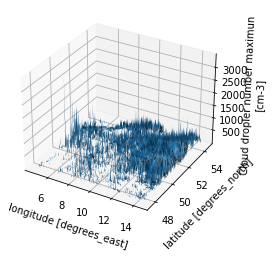

In [4]:
ds.Nd_max.where(ds.Nd_max > 2).plot.surface()

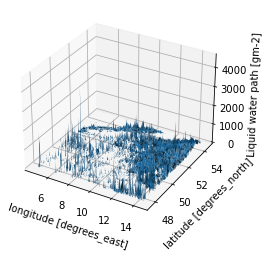

In [5]:
ds.lwp.where(ds.lwp != 0).plot.surface()

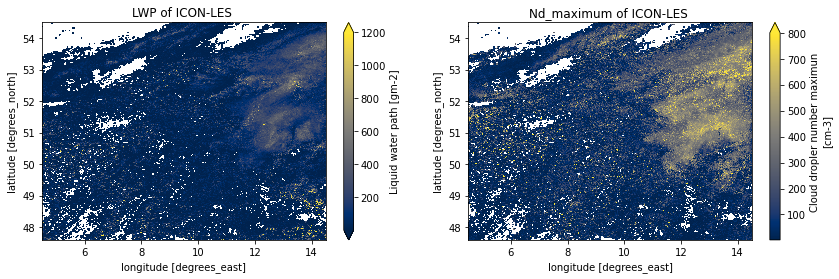

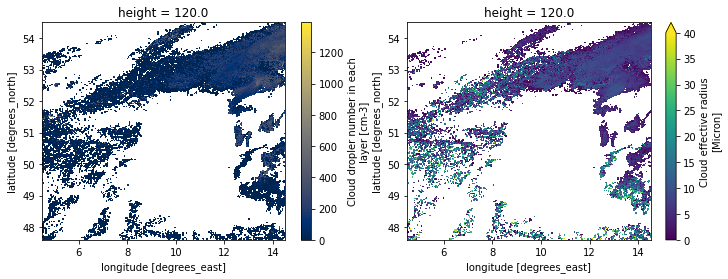

In [6]:
fig = plt.figure(figsize=(14, 4))
plt.subplot(121)
ds.lwp.where(ds.lwp != 0).plot(cmap = "cividis", vmin=2, vmax = 1200)
plt.gca().set_title(f"LWP of ICON-LES ")
plt.subplot(122)
ds.Nd_max.where(ds.Nd_max > 2).plot(cmap = "cividis", vmin=2, vmax = 800) 
plt.gca().set_title(f"Nd_maximum of ICON-LES ")



fig = plt.figure(figsize=(12, 4))
plt.subplot(121)
ds.Nd[119,:,:].where(ds.Nd[119,:,:] != 0).plot(cmap = "cividis") #,vmin=2, vmax = 800)
plt.subplot(122)
# ds.Reff[119].where(ds.Reff != 0).plot(cmap = "jet",vmin=2, vmax = 800)
ds.Reff[119,:,].plot(vmin=0, vmax = 40)


Text(0.5, 1.0, 'Nd_maximum of ICON-LES ')

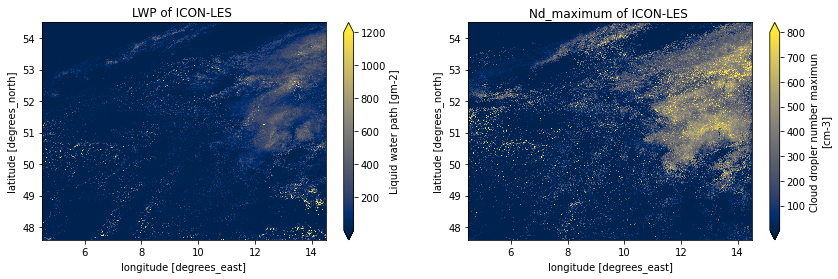

In [16]:
fig = plt.figure(figsize=(14, 4))
plt.subplot(121)
ds.lwp.plot(cmap = "cividis", vmin=2, vmax = 1200)
plt.gca().set_title(f"LWP of ICON-LES ")
plt.subplot(122)
ds.Nd_max.plot(cmap = "cividis", vmin=2, vmax = 800) 
plt.gca().set_title(f"Nd_maximum of ICON-LES ")


In [22]:
print("LWP min: {}, max: {}".format(ds["lwp"].values.min(), np.max(ds["lwp"].values)))
print("Nd_max min: {}, max: {}".format(ds["Nd_max"].values.min(), np.max(ds["Nd_max"].values)))


LWP min: 0.0, max:4600.84033203125
Nd_max min: 0.0, max:3446.759207242138


In [27]:
print("pres min: {}, max: {}, mean: {}".format(ds["pres"].values.min(), np.max(ds["pres"].values), ds["pres"].values.mean()))
print("ta min: {}, max: {}, mean: {}".format(ds["ta"].values.min(), np.max(ds["ta"].values),ds["ta"].values.mean()))
print("hus min: {}, max: {}, mean: {}".format(ds["hus"].values.min(), np.max(ds["hus"].values), ds["hus"].values.mean()))

pres min: 4933.36865234375, max: 103661.1328125, mean: 47338.640625
ta min: 210.57948303222656, max: 295.9921569824219, mean: 247.1776885986328
hus min: 2.489518010406755e-06, max: 0.011469095014035702, mean: 0.0018195133889093995


In [164]:
df_1d = pd.DataFrame({  #falta normalizar
    "Nd_max" : ds.Nd_max.values.flatten(),
    "LWP" : ds["lwp"].values.flatten() }) 

df_1d.describe()

,Nd_max,LWP
count,369892.0,369892.0
mean,114.7,62.1
std,170.2,126.2
min,0.0,0.0
25%,0.0,0.0
50%,15.0,2.5
75%,194.7,70.5
max,3446.8,4600.8


In [21]:
PC.all() ==X_reduced.all()

True

In [22]:
pca

PCA(n_components=24)

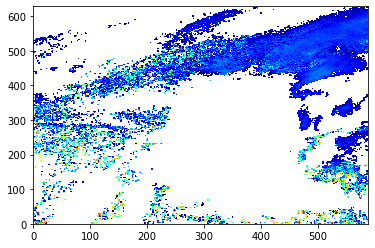

In [24]:
plt.pcolormesh(ds.Reff[119], cmap ='jet') #, vmin=0,vmax=55) #cmap=cmap.N, norm=norm)


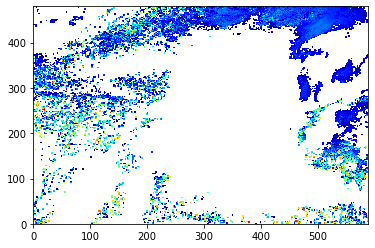

In [26]:
plt.pcolormesh(ds.Reff[119,:480,:], cmap ='jet') #, vmin=0,vmax=55) #cmap=cmap.N, norm=norm)

ValueError: too many values to unpack (expected 2)

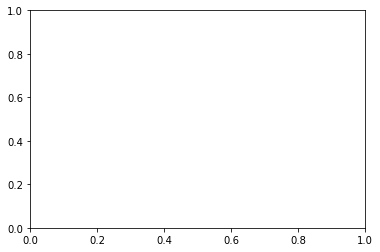

In [37]:
plt.pcolormesh(ds_2d.Reff, cmap ='jet') #, vmin=0,vmax=55) #cmap=cmap.N, norm=norm)

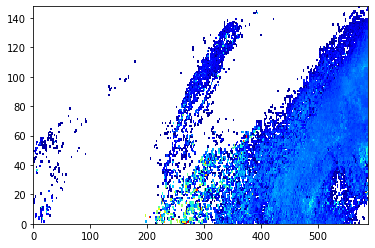

In [27]:
plt.pcolormesh(ds.Reff[119,480:,:], cmap ='jet') #, vmin=0,vmax=55) #cmap=cmap.N, norm=norm)

In [ ]:
plt.pcolormesh(ds.Reff[119,:480,:], cmap ='jet') #, vmin=0,vmax=55) #cmap=cmap.N, norm

In [ ]:
    X_train = ds.Reff[:,:480,:]
    y_train = ds.Reff[:,480:,]

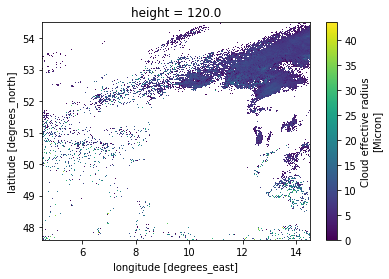

In [4]:
ds.Reff[119].plot()#, vmin=0,vmax=55) #cmap=cmap.N, norm=norm)


In [4]:
ds = xr.open_dataset("/work/bb1036/b381362/dataset/data_rttov_T12_Reff_cut.nc")
ds

<xarray.Dataset>
Dimensions:       (lat: 628, lon: 589, height: 150)
Coordinates:
  * height        (height) float64 1.0 2.0 3.0 4.0 ... 147.0 148.0 149.0 150.0
  * lat           (lat) float64 47.6 47.61 47.62 47.63 ... 54.47 54.48 54.5
  * lon           (lon) float64 4.5 4.517 4.534 4.551 ... 14.45 14.46 14.48 14.5
Data variables: (12/20)
    FR_LAND       (lat, lon) float32 ...
    Nd            (height, lat, lon) float64 ...
    Nd_max        (lat, lon) float64 ...
    Reff          (height, lat, lon) float64 ...
    clc           (height, lat, lon) float32 ...
    cli           (height, lat, lon) float32 ...
    ...            ...
    t_s           (lat, lon) float32 ...
    ta            (height, lat, lon) float32 ...
    tas           (lat, lon) float32 ...
    topography_c  (lat, lon) float32 ...
    u_10m         (lat, lon) float32 ...
    v_10m         (lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.4
    uuidOfVGrid:  3be5ac35-92f4-4e91-7418-b62336222e20
    title:        ICON simulation
    history:      Wed Jun 15 17:49:52 2022: ncks -d lat,47.599,54.5 /work/bb1...
    references:   see MPIM/DWD publications
    comment:      HDCP2 Sammelaccount (k203095) on m21726 (Linux 2.6.32-696.1...
    NCO:          netCDF Operators version 5.0.6 (Homepage = http://nco.sf.ne...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [5]:
T_c =  np.float64(ds.ta) - 273.15
print(T_c.min(),T_c.max())
esat_2013 = 0.611* np.exp((17.3*T_c)/(T_c+237.3))*1000.0
#esat_2013 = np.ma.masked_array(esat_2013,  esat_2013 == 0) ## check it!!!!!!!!
print(esat_2013.min(),esat_2013.max())

pres = np.ma.masked_array(ds.pres,  ds.pres == 0) ## check it!!!!!!!!
print(pres.min(),pres.max())

qs_2013 =  0.622* (esat_2013/pres)
print(qs_2013.min(),qs_2013.max())
r_2013 = ds.hus/(1 - ds.hus)
print(r_2013.min(),r_2013.max())
RH_2013 = 100*(r_2013/qs_2013)
print(RH_2013.min(),RH_2013.max())
pv_2013 = (esat_2013 * RH_2013)/100.0
print(pv_2013.min(),pv_2013.max())
pd_2013 = ds.pres - pv_2013
print(pd_2013.min(),pd_2013.max())
rho_2013 = (pd_2013/(287.058 * ds.ta)) + (pv_2013/(461.495 * ds.ta))  #nana
print(rho_2013.min(),rho_2013.max())

#-----------------Calculation of the Reff -------------------------
L  = rho_2013*ds.clw # in kgm^-3
N = rho_2013*ds.qnc # im m^-3
# L.where(L == 0, np.Nan, L)
# N.where(N < 2.0e+06, np.Nan, N) !! ask DIPU
######constant for size distribution #############
nu = 1.0
mu = 1.0
a = 1.24E-01
b = 1/3

-62.570516967773415 22.842156982421898
1.2460492424413752 2790.9808998945614
4933.3687 103661.13
3.584466855046453e-05 0.01763056200402201
<xarray.DataArray 'hus' ()>
array(2.48952415e-06) <xarray.DataArray 'hus' ()>
array(0.01160216)
<xarray.DataArray 'hus' ()>
array(0.61525011) <xarray.DataArray 'hus' ()>
array(115.79605846)
<xarray.DataArray 'hus' ()>
array(0.03072338) <xarray.DataArray 'hus' ()>
array(1801.70568026)
<xarray.DataArray ()>
array(4933.33742426) <xarray.DataArray ()>
array(102557.86554564)
<xarray.DataArray ()>
array(0.07751149) <xarray.DataArray ()>
array(1.2806839)


In [6]:
print("N",np.max(N), N.min())


N <xarray.DataArray ()>
array(3.44675921e+09) <xarray.DataArray ()>
array(0.)


In [7]:
L  = rho_2013*ds.clw # in kgm^-3
N = rho_2013*ds.qnc # im m^-3

L2 = np.ma.masked_array(L,  L == 0) ## check it!!!!!!!!
N2 = np.ma.masked_array(N,  N < 2.0e+06) ## check it!!!!!!!!

###################################
reff_2013 = (a/2) * (gamma((3*b+nu+1)/(mu))/gamma((2*b+nu+1)/(mu)))*((L2/N2)*(gamma((nu+1)/(mu))/gamma((nu+2)/mu)))**(b)
reff_2013 = reff_2013*1E6
print("Reff",np.max(reff_2013), reff_2013.min())

Reff 51.41350521665602 7.933216967374964e-11


In [8]:
L  = rho_2013*ds.clw # in kgm^-3
N = rho_2013*ds.qnc # im m^-3

#L2 = np.ma.masked_array(L,  L == 0) ## check it!!!!!!!!
N2 = np.ma.masked_array(N,  N < 2.0e+06) ## check it!!!!!!!!

###################################
reff_2013 = (a/2) * (gamma((3*b+nu+1)/(mu))/gamma((2*b+nu+1)/(mu)))*((L/N2)*(gamma((nu+1)/(mu))/gamma((nu+2)/mu)))**(b)
reff_2013 = reff_2013*1E6
print("Reff",np.max(reff_2013), reff_2013.min())

Reff <xarray.DataArray ()>
array(51.41350522) <xarray.DataArray ()>
array(0.)


In [16]:
reff_2013

<xarray.DataArray (height: 150, lat: 628, lon: 589)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * height   (height) float64 1.0 2.0 3.0 4.0 5.0 ... 147.0 148.0 149.0 150.0
  * lat      (lat) float64 47.6 47.61 47.62 47.63 ... 54.46 54.47 54.48 54.5
  * lon      (lon) float64 4.5 4.517 4.534 4.551 ... 14.45 14.46 14.48 14.5

In [14]:
ds["Reff2"] =  reff_2013 #thi is a xarray.DataArray
ds.Reff2.attrs['units'] = "Micron"
ds.Reff2.attrs['standard_name'] = "Reff"
ds.Reff2.attrs['long_name'] = "Cloud effective radius"

MissingDimensionsError: cannot set variable 'Reff2' with 3-dimensional data without explicit dimension names. Pass a tuple of (dims, data) instead.

In [9]:
ds.Reff2.max(), ds.Reff2.min()

(<xarray.DataArray 'Reff2' ()>
 array(51.41350522),
 <xarray.DataArray 'Reff2' ()>
 array(0.))

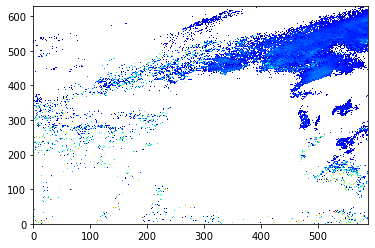

In [11]:
plt.pcolormesh(ds.Reff2[119], cmap ='jet') #, vmin=0,vmax=55) #cmap=cmap.N, norm=norm)


AttributeError: 'Rectangle' object has no property 'vmin'

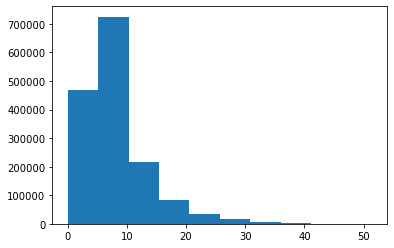

In [29]:
# air2d = L.isel(height=119)

reff_2013.plot(vmin=0,vmax=55)

In [5]:
print("Reff",np.max(reff_2013), reff_2013.min())


Reff 51.41350521665602 7.933216967374964e-11


In [7]:
b =reff_2013
b

masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        ...,

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --,

In [30]:
print('===============Reff (height 120, lat 57, lon 227) 17.20 um == ', ds.Reff[119, 56, 226])

===============Reff (height 120, lat 57, lon 227) 17.20 um ==  <xarray.DataArray ()>
array(17.20233612)
Coordinates:
    height   float64 120.0
    lat      float64 48.12
    lon      float64 8.342


In [40]:
print('===============Reff (height 120, lat 57, lon 227) 17.20 um == ', ds.Reff[119, 56-9, 226])

===============Reff (height 120, lat 57, lon 227) 17.20 um ==  <xarray.DataArray 'Reff' ()>
array(17.202336)
Coordinates:
    height   float64 120.0
    lat      float64 48.12
    lon      float64 8.342
Attributes:
    units:          Micron
    standard_name:  Reff
    long_name:      Cloud effective radius


In [43]:
import pandas as pd

df_1d = pd.DataFrame({  #falta normalizar
    "Reff" : ds.Reff.values.flatten() }) 
df_1d.describe()


,Reff
count,2.486024e+06
mean,inf
std,NaN
min,0.000000e+00
25%,4.212784e+00
50%,7.867323e+00
75%,1.915845e+01
max,inf


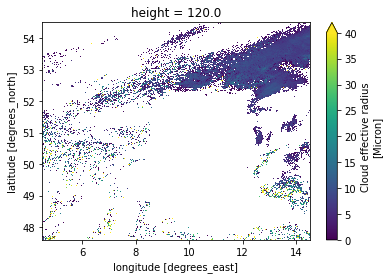

In [45]:
air2d = ds.Reff.isel(height=119)

air2d.plot(vmin=0,vmax=40)

-62.570516967773415 22.842156982421898
1.2460492424413752 2790.9808998945614
4933.3687 103661.13
3.584466855046453e-05 0.01763056200402201
<xarray.DataArray 'hus' ()>
array(2.48952415e-06) <xarray.DataArray 'hus' ()>
array(0.01160216)
<xarray.DataArray 'hus' ()>
array(0.61525011) <xarray.DataArray 'hus' ()>
array(115.79605846)
<xarray.DataArray 'hus' ()>
array(0.03072338) <xarray.DataArray 'hus' ()>
array(1801.70568026)
<xarray.DataArray ()>
array(4933.33742426) <xarray.DataArray ()>
array(102557.86554564)
<xarray.DataArray ()>
array(0.07751149) <xarray.DataArray ()>
array(1.2806839)


In [ ]:
ds["Reff"] =  reff_2013 #thi is a xarray.DataArray
ds.Reff.attrs['units'] = "Micron"
ds.Reff.attrs['standard_name'] = "Reff"
ds.Reff.attrs['long_name'] = "Cloud effective radius"

In [46]:
L.max(), L.min()

(<xarray.DataArray ()>
 array(0.00303497),
 <xarray.DataArray ()>
 array(0.))

In [47]:
N.max(), N.min()

(<xarray.DataArray ()>
 array(3.44675921e+09),
 <xarray.DataArray ()>
 array(0.))

In [14]:
np.nanmax(reff_2013.values), reff_2013.values.min()

(inf, nan)

In [15]:
print('===============Reff (height 120, lat 57, lon 227) 17.20 um == ', reff_2013[119-9, 56, 226])

===============Reff (height 120, lat 57, lon 227) 17.20 um ==  <xarray.DataArray ()>
array(nan)
Coordinates:
    height   float64 111.0
    lat      float64 48.12
    lon      float64 8.342


In [18]:
cdnc_2013_cm = (rho_2013 * ds.qnc)/1000000 # convert to cm^-3
print(cdnc_2013_cm.min(),cdnc_2013_cm.max())

Nd_max = np.nanmax(cdnc_2013_cm, axis = 0)
print(Nd_max.min(),Nd_max.max())

ds = ds.assign(lwp = ds.clwvi*1000)
print(ds.lwp.min(),ds.lwp.max())

<xarray.DataArray ()>
array(0.) <xarray.DataArray ()>
array(3446.75920724)
0.0 3446.759207242138
<xarray.DataArray 'lwp' ()>
array(0.) <xarray.DataArray 'lwp' ()>
array(4600.84033203)


In [28]:
np.nanmax(reff_2013), reff_2013.min()

(inf,
 <xarray.DataArray ()>
 array(0.))

In [31]:
print('===============Reff (height 120, lat 57, lon 227) 17.20 um == ', reff_2013[119-9, 56, 226])

===============Reff (height 120, lat 57, lon 227) 17.20 um ==  <xarray.DataArray ()>
array(nan)
Coordinates:
    height   float64 111.0
    lat      float64 48.22
    lon      float64 8.342


In [29]:
reff_2013

<bound method ImplementsArrayReduce._reduce_method.<locals>.wrapped_func of <xarray.DataArray (height: 150, lat: 628, lon: 589)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],


In [26]:
reff_2013_a = np.ma.masked_array(reff_2013,  reff_2013 != -np.inf) ## check it!!!!!!!!
np.nanmax(reff_2013_a)

masked

In [9]:
#####################
beta_z = (3/2)*(L/(ds.Reff*1000)) # Q_ext=is 2, and rhow_w = 1000 kg/m3
T_v = ds.ta/(1-(pv_2013/ds.pres)*(1-0.622))
g=9.8 # ms^-2
R=287.058 #m^2s^-2K^-1 (J~kgm^2s^-2)
#####################################
####################################
cot_lyr = np.zeros((len(ds.height.values), len(ds.lat.values), len( ds.lon.values)))
cot = np.zeros((len(ds.lat.values), len(ds.lon.values)))

In [21]:
arr = np.empty((5,5))
arr[:] = np.NaN
print(arr)

[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]


In [28]:
np.shape(cot), np.shape(cot_lyr)

((628, 589), (150, 628, 589))

In [11]:
len(ds.lon.values)

589

In [12]:
n_lon = 2 #len(ds.lon.values)
n_lat = 2 #len(ds.lat.values)
n_height = 3 #len(ds.height.values)
for i in range(n_lon): 
    for j in range(n_lat): 
        for k in range(n_height-1): 
            dz = ((R*T_v[k,j,i])/g)*(np.log(ds.pres[k+1,j,i]/ds.pres[k,j,i]))
            cot_lyr[k,j,i] = ((beta_z[k+1,j,i] + beta_z[k,j,i])/2)*dz             
       
        cot[j,i] = np.nansum(cot_lyr[:,j,i]) 

In [19]:
cot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
print("COT min, max", ds.cot.values.min(), np.max(ds.cot.values))


COT min, max 0.0 0.0


In [15]:
ds["cot"]=(['lat', 'lon'],  cot) #this is an array
ds.cot.attrs['units'] = ""
ds.cot.attrs['standard_name'] = "COD/COT"
ds.cot.attrs['long_name'] = "Cloud optical thickness"



In [ ]:
ds["cot"].plot(cmap = "jet") #,vmin=2, vmax = 1200)


In [ ]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
ds["lwp2"] =ds.clwvi*1000
ds["lwp2"] .where(ds["lwp2"] != 0).plot(cmap = "jet",vmin=2, vmax = 1200)


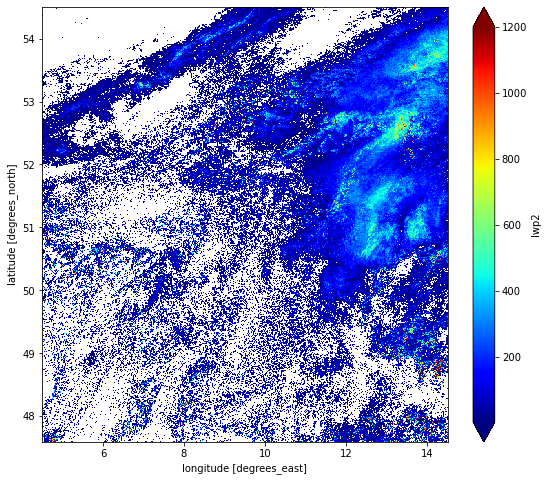

In [3]:

# ds = xr.open_dataset("/work/bb1036/b381362/dataset/data_rttov_T12.nc")
#ds = xr.open_dataset("/work/bb1036/b381362/dataset/data_rttov_T12_Reff_cut.nc")
ds2 = xr.open_dataset("/work/bb1036/b381362/dataset/data_rttov_T12_Reff_cut.nc")


ds2

plt.figure(figsize=(20, 8))
plt.subplot(121)
ds2["lwp2"] =ds2.clwvi*1000
ds2["lwp2"].where(ds2["lwp2"] != 0).plot(cmap = "jet",vmin=2, vmax = 1200)


In [5]:
(ds.clwvi[9:,:]==ds2.clwvi).all()

<xarray.DataArray 'clwvi' ()>
array(False)

In [5]:
import pandas as pd

df_1d = pd.DataFrame({  #falta normalizar
    "Nd_max" : ds2.Nd_max.values.flatten(),
    # "LWP" : ds["lwp"].values.flatten()
    "LWP" : ds2["lwp"].values.flatten() }) 
df_1d.describe()

n_zeros1 = np.count_nonzero(df_1d["Nd_max"]==0)
n_zeros2 = np.count_nonzero( df_1d["LWP"]==0)
n_zeros1, n_zeros2

(117448, 157627)

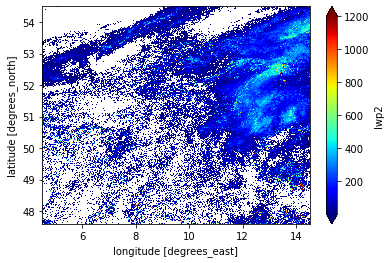

In [11]:
ds["lwp2"].where(ds["lwp2"] != 0).plot(cmap = "jet",vmin=2, vmax = 1200)


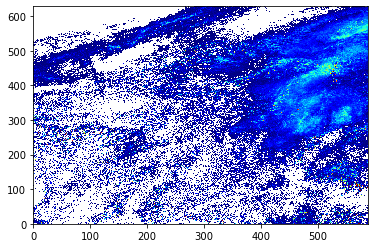

In [15]:
lwp_2013 = np.ma.masked_array(ds["lwp2"],  ds["lwp2"] == 0) ## check it!!!!!!!!

plt.pcolormesh(lwp_2013, cmap ='jet', vmin=2, vmax = 1200 ) #cmap=cmap.N, norm=norm)


In [20]:
import pandas as pd

df_1d = pd.DataFrame({  #falta normalizar
    "Nd_max" : ds.Nd_max.values.flatten(),
    # "LWP" : ds["lwp"].values.flatten()
    "LWP" : ds["lwp"].values.flatten() }) 
df_1d.describe()

,Nd_max,LWP
count,369892.000000,369892.000000
mean,114.661964,62.101212
std,170.231963,126.286911
min,0.000000,0.000000
25%,0.000000,0.000000
50%,15.015653,2.493243
75%,194.732379,70.504786
max,3446.759207,4600.840332


In [9]:
T_c =  np.float64(ds.ta) - 273.15
print(T_c.min(),T_c.max())
esat_2013 = 0.611* np.exp((17.3*T_c)/(T_c+237.3))*1000.0
#esat_2013 = np.ma.masked_array(esat_2013,  esat_2013 == 0) ## check it!!!!!!!!
print(esat_2013.min(),esat_2013.max())

pres = np.ma.masked_array(ds.pres,  ds.pres == 0) ## check it!!!!!!!!
print(pres.min(),pres.max())

qs_2013 =  0.622* (esat_2013/pres)
print(qs_2013.min(),qs_2013.max())
r_2013 = ds.hus/(1 - ds.hus)
print(r_2013.min(),r_2013.max())
RH_2013 = 100*(r_2013/qs_2013)
print(RH_2013.min(),RH_2013.max())
pv_2013 = (esat_2013 * RH_2013)/100.0
print(pv_2013.min(),pv_2013.max())
pd_2013 = ds.pres - pv_2013
print(pd_2013.min(),pd_2013.max())
rho_2013 = (pd_2013/(287.058 * ds.ta)) + (pv_2013/(461.495 * ds.ta))  #nana
print(rho_2013.min(),rho_2013.max())

-62.570516967773415 22.842156982421898
1.2460492424413752 2790.9808998945614
4933.3687 103661.13
3.584466855046453e-05 0.01763056200402201
<xarray.DataArray 'hus' ()>
array(2.48952415e-06) <xarray.DataArray 'hus' ()>
array(0.01160216)
<xarray.DataArray 'hus' ()>
array(0.61525011) <xarray.DataArray 'hus' ()>
array(115.79605846)
<xarray.DataArray 'hus' ()>
array(0.03072338) <xarray.DataArray 'hus' ()>
array(1801.70568026)
<xarray.DataArray ()>
array(4933.33742426) <xarray.DataArray ()>
array(102557.86554564)
<xarray.DataArray ()>
array(0.07751149) <xarray.DataArray ()>
array(1.2806839)


<xarray.DataArray ()>
array(0.) <xarray.DataArray ()>
array(3446.75920724)
0.0 3446.759207242138
<xarray.DataArray 'lwp' ()>
array(0.) <xarray.DataArray 'lwp' ()>
array(6158.81933594)


In [ ]:


ds.lwp.attrs['units'] = "gm-2"
ds.lwp.attrs['standard_name'] = "LWP"
ds.lwp.attrs['long_name'] = "Liquid water path"



ds["Nd_max"]=(['lat', 'lon'],  Nd_max) #this is an array
ds.Nd_max.attrs['units'] = "cm-3"
ds.Nd_max.attrs['standard_name'] = "Nd_max"
ds.Nd_max.attrs['long_name'] = "Cloud dropler number maximun"

ds["Nd"] =  cdnc_2013_cm #thi is a xarray.DataArray
ds.Nd.attrs['units'] = "cm-3"
ds.Nd.attrs['standard_name'] = "Nd"
ds.Nd.attrs['long_name'] = "Cloud dropler number in each layer"


#-----------------Calculation of the Reff -------------------------
L  = rho_2013*ds.clw # in kgm^-3
N = rho_2013*ds.qnc # im m^-3
# L.where(L == 0, np.Nan, L)
# N.where(N < 2.0e+06, np.Nan, N) !! ask DIPU
######constant for size distribution #############
nu = 1.0
mu = 1.0
a = 1.24E-01
b = 1/3

###################################
reff_2013 = (a/2) * (gamma((3*b+nu+1)/(mu))/gamma((2*b+nu+1)/(mu)))*((L/N)*(gamma((nu+1)/(mu))/gamma((nu+2)/mu)))**(b)
reff_2013 = reff_2013*1E6

ds["Reff"] =  reff_2013 #thi is a xarray.DataArray
ds.Reff.attrs['units'] = "Micron"
ds.Reff.attrs['standard_name'] = "Reff"
ds.Reff.attrs['long_name'] = "Cloud effective radius"


In [ ]:
print("next values only work with data_rttov_12")
print('===============T_2013 (height 120, lat 57, lon 227) cm: 276.151153564453 == ', ds.ta[119, 56, 226])
print('===============T_c (height 120, lat 57, lon 227) cm: 3.00115356445315== ', T_c[119, 56, 226])
print('===============esat_2013 (height 120, lat 57, lon 227) 758.360598313415 == ', esat_2013[119, 56, 226]) #3 mmmmm no sale igual
print('===============p_2013 (height 120, lat 57, lon 227)75935.328125 == ', ds.pres[119, 56, 226]) 
print('===============qs_2013 (height 120, lat 57, lon 227) 0.00621186875461262  == ', qs_2013[119, 56, 226]) #3 mmmmm no sale igual
print('===============r_2013 (height 120, lat 57, lon 227) 0.0062973626597643 == ', r_2013[119, 56, 226])
print('===============RH_2013 (height 120, lat 57, lon 227) 101.376299283339 == ', RH_2013[119, 56, 226])
print('===============pv_2013 (height 120, lat 57, lon 227) 768.797909793127 == ', pv_2013[119, 56, 226])
print('===============pd_2013 (height 120, lat 57, lon 227) 75166.5302152069 == ', pd_2013[119, 56, 226])
print('===============rho_2013 (height 120, lat 57, lon 227) 0.954250058491486 == ', rho_2013[119, 56, 226]) #3 mmmmm no sale igual
print('===============cdnc_2013_cm (height 120, lat 57, lon 227) 15.5508091629487 == ', cdnc_2013_cm[119, 56, 226])
print('===============Reff (height 120, lat 57, lon 227) 17.20 um == ', reff_2013[119, 56, 226])
ds.to_netcdf('/home/jvillarreal/Documents/phd/dataset/data_rttov_T12_reff.nc') 

In [21]:
 #(ds.Nd_max.values[9:,:]==Nd_max).all()

True

In [17]:
i= 205
j= 57
print(np.max(cdnc_2013_cm[:,i,j].values),'debe ser igual to', Nd_max[i,j])


10.791630001595426 debe ser igual to 10.791630001595426


In [52]:
import pandas as pd

df_1d = pd.DataFrame({  #falta normalizar
    "Nd_max" : ds.Nd_max.values.flatten(),
    # "LWP" : ds["lwp"].values.flatten()
    "LWP" : ds["lwp"].values.flatten() }) 
df_1d.describe()

,Nd_max,LWP
count,369892.000000,375193.000000
mean,114.661964,59.209698
std,170.231963,121.161110
min,0.000000,0.000000
25%,0.000000,0.000000
50%,15.015653,2.529513
75%,194.732379,67.780930
max,3446.759207,6158.819336


In [3]:
ds = xr.open_dataset("/work/bb1036/b381362/dataset/data_rttov_T12_Reff.nc")
ds2 = xr.open_dataset("/work/bb1036/b381362/dataset/data_rttov_T12_Reff_cut.nc")
# ds = xr.open_dataset("/home/jvillarreal/Documents/phd/dataset/data_rttov_T12.nc")
ds2

<xarray.Dataset>
Dimensions:       (lat: 628, lon: 589, height: 150)
Coordinates:
  * height        (height) float64 1.0 2.0 3.0 4.0 ... 147.0 148.0 149.0 150.0
  * lat           (lat) float64 47.6 47.61 47.62 47.63 ... 54.47 54.48 54.5
  * lon           (lon) float64 4.5 4.517 4.534 4.551 ... 14.45 14.46 14.48 14.5
Data variables: (12/20)
    FR_LAND       (lat, lon) float32 ...
    Nd            (height, lat, lon) float64 ...
    Nd_max        (lat, lon) float64 ...
    Reff          (height, lat, lon) float64 ...
    clc           (height, lat, lon) float32 ...
    cli           (height, lat, lon) float32 ...
    ...            ...
    t_s           (lat, lon) float32 ...
    ta            (height, lat, lon) float32 ...
    tas           (lat, lon) float32 ...
    topography_c  (lat, lon) float32 ...
    u_10m         (lat, lon) float32 ...
    v_10m         (lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.4
    uuidOfVGrid:  3be5ac35-92f4-4e91-7418-b62336222e20
    title:        ICON simulation
    history:      Wed Jun 15 11:06:10 2022: ncks -d lat,47.599,54.5 /work/bb1...
    references:   see MPIM/DWD publications
    comment:      HDCP2 Sammelaccount (k203095) on m21726 (Linux 2.6.32-696.1...
    NCO:          netCDF Operators version 5.0.6 (Homepage = http://nco.sf.ne...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [6]:
ds2["Nd_max"][:2,:]

<xarray.DataArray 'Nd_max' (lat: 2, lon: 589)>
array([[  0.      ,   0.      ,   0.      , ...,  92.653012,  99.895502,
          0.      ],
       [  0.      ,   0.      ,  70.424703, ...,  82.186069, 113.765356,
          0.      ]])
Coordinates:
  * lat      (lat) float64 47.6 47.61
  * lon      (lon) float64 4.5 4.517 4.534 4.551 ... 14.45 14.46 14.48 14.5
Attributes:
    units:          cm-3
    standard_name:  Nd_max
    long_name:      Cloud dropler number maximun

In [7]:
ds.lat[0:10]

<xarray.DataArray 'lat' (lat: 10)>
array([47.5  , 47.511, 47.522, 47.533, 47.544, 47.555, 47.566, 47.577, 47.588,
       47.599])
Coordinates:
  * lat      (lat) float64 47.5 47.51 47.52 47.53 ... 47.57 47.58 47.59 47.6
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y

In [8]:
ds["Nd_max"][:10,:]

<xarray.DataArray 'Nd_max' (lat: 10, lon: 589)>
array([[      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [ 0.      ,  0.      ,  0.      , ..., 92.653012, 99.895502,  0.      ]])
Coordinates:
  * lat      (lat) float64 47.5 47.51 47.52 47.53 ... 47.57 47.58 47.59 47.6
  * lon      (lon) float64 4.5 4.517 4.534 4.551 ... 14.45 14.46 14.48 14.5
Attributes:
    units:          cm-3
    standard_name:  Nd_max
    long_name:      Cloud dropler number maximun

In [53]:
import pandas as pd

df_d = pd.DataFrame({  #falta normalizar
    "Nd_max" : (ds.Nd_max[9:,:].values).flatten(),
    # "LWP" : ds["lwp"].values.flatten()
    "LWP" : ds["lwp"][9:,:].values.flatten()

}) 
df_d.describe()

,Nd_max,LWP
count,369892.000000,369892.000000
mean,114.661964,59.349442
std,170.231963,119.943024
min,0.000000,0.000000
25%,0.000000,0.000000
50%,15.015653,2.687319
75%,194.732379,68.916622
max,3446.759207,6158.819336


In [50]:
df_1d

,Nd_max,LWP
0,0.000000,0.000000
1,0.000000,0.000000
2,0.000000,0.000000
3,12.242780,0.000000
4,22.199962,0.000000
...,...,...
369887,61.928620,0.000000
369888,8.552532,96.927086
369889,90.854551,0.000000
369890,99.569847,10.177068


In [ ]:
(117448, 157627)

In [46]:
n_zeros = np.count_nonzero(df_1d["Nd_max"]==0)
n_zeros

117448

In [49]:
n_zeros = np.count_nonzero( df_1d["LWP"]==0)
n_zeros

156997

In [37]:
117448 - 159978

-42530

In [23]:
np.size(Nd_max)

375193

In [24]:
369892 - 375193

-5301

In [33]:
375193 - 375193

0

<xarray.DataArray 'lwp' ()>
array(0.) <xarray.DataArray 'lwp' ()>
array(6158.81933594)


/tmp/ipykernel_3876620/2696298162.py:8: RuntimeWarning: All-NaN axis encountered
  Nd_max = np.nanmax(cdnc_2013_cm, axis = 0)


nan nan


In [ ]:
ds.close()

In [3]:
#https://geohackweek.github.io/nDarrays/09-masking/ masking array

In [16]:
#https://docs.xarray.dev/en/stable/user-guide/data-structures.html#dictionary-like-methods

<xarray.Dataset>
Dimensions:       (lat: 637, lon: 589, height: 150)
Coordinates:
  * height        (height) float64 1.0 2.0 3.0 4.0 ... 147.0 148.0 149.0 150.0
  * lat           (lat) float64 47.5 47.51 47.52 47.53 ... 54.47 54.48 54.5
  * lon           (lon) float64 4.5 4.517 4.534 4.551 ... 14.45 14.46 14.48 14.5
Data variables: (12/21)
    FR_LAND       (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    cct           (lat, lon) float32 0.0 0.0 0.0 0.0 ... -999.0 7.681e+04 0.0
    clc           (height, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cli           (height, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    clw           (height, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    clwvi         (lat, lon) float32 0.0 8.124e-06 8.124e-06 ... 0.01018 0.04625
    ...            ...
    tas           (lat, lon) float32 289.8 289.9 289.9 ... 279.3 279.4 279.3
    topography_c  (lat, lon) float32 411.2 411.7 411.7 393.6 ... 0.0 0.0 0.

/home/jvillarreal/Documents/phd/github/ICON_RTTOV/code_test/lwp_nd.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, z, cmap ='jet', vmin=vmin, vmax = vmax ) #cmap=cmap.N, norm=norm)


===============T_2013 (height 120, lat 57, lon 227) cm: 276.151153564453 ==  276.40933
===============T_c (height 120, lat 57, lon 227) cm: 3.00115356445315==  3.2593384
===============esat_2013 (height 120, lat 57, lon 227) 758.360598313415 ==  772.3939
===============p_2013 (height 120, lat 57, lon 227)75935.328125 ==  76403.13
===============qs_2013 (height 120, lat 57, lon 227) 0.00621186875461262  ==  0.00628808
===============r_2013 (height 120, lat 57, lon 227) 0.0062973626597643 ==  0.004533605
===============RH_2013 (height 120, lat 57, lon 227) 101.376299283339 ==  72.098404
===============pv_2013 (height 120, lat 57, lon 227) 768.797909793127 ==  556.88367
===============pd_2013 (height 120, lat 57, lon 227) 75166.5302152069 ==  75846.25
===============rho_2013 (height 120, lat 57, lon 227) 0.954250058491486 ==  0.960264
===============cdnc_2013_cm (height 120, lat 57, lon 227) 15.5508091629487 ==  0.0


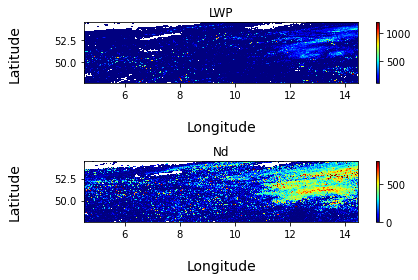

In [1]:

from lwp_nd import lwp_nd_input_ICON

path_ICON = "/home/jvillarreal/Documents/phd/dataset/data_rttov_T12.nc"
path_output = "/home/jvillarreal/Documents/phd/output/input_icon"
ds,p_2013, T_2013, q_2013, max_cdnc_2013_cm, lwp_2013, lat, lon, height = lwp_nd_input_ICON(path_output = path_output,  path_ICON = path_ICON)


In [1]:
import xarray as xr
ds = xr.open_dataset("/home/jvillarreal/Documents/phd/dataset/data_rttov_T12_Reff.nc")

In [2]:

print("next values only work with data_rttov_12")
print('===============T_2013 (height 120, lat 57, lon 227) cm: 276.151153564453 == ', ds.ta[119, 56, 226])
print('===============p_2013 (height 120, lat 57, lon 227)75935.328125 == ', ds.pres[119, 56, 226]) 
print('===============cdnc_2013_cm (height 120, lat 57, lon 227) 15.5508091629487 == ', ds.Nd[119, 56, 226])
print('===============Reff (height 120, lat 57, lon 227) 17.20 um == ', ds.Reff[119, 56, 226])


next values only work with data_rttov_12
===============T_2013 (height 120, lat 57, lon 227) cm: 276.151153564453 ==  <xarray.DataArray 'ta' ()>
array(276.15115, dtype=float32)
Coordinates:
    height   float64 120.0
    lat      float64 48.12
    lon      float64 8.342
Attributes:
    standard_name:  air_temperature
    long_name:      Temperature
    units:          K
    param:          0.0.0
    cell_methods:   time: mean
    institution:    MPIMET
===============p_2013 (height 120, lat 57, lon 227)75935.328125 ==  <xarray.DataArray 'pres' ()>
array(75935.33, dtype=float32)
Coordinates:
    height   float64 120.0
    lat      float64 48.12
    lon      float64 8.342
Attributes:
    standard_name:  air_pressure
    long_name:      Pressure
    units:          Pa
    param:          0.3.0
    cell_methods:   time: mean
    institution:    MPIMET
===============cdnc_2013_cm (height 120, lat 57, lon 227) 15.5508091629487 ==  <xarray.DataArray 'Nd' ()>
array(15.550809)
Coordinates:
    

In [3]:
print('===============Reff (height 120, lat 57, lon 227) 17.20 um == ', ds.Reff[119, 56, 226])


===============Reff (height 120, lat 57, lon 227) 17.20 um ==  <xarray.DataArray 'Reff' ()>
array(17.202336)
Coordinates:
    height   float64 120.0
    lat      float64 48.12
    lon      float64 8.342
Attributes:
    units:          Micron
    standard_name:  Reff
    long_name:      Cloud effective radius


In [8]:
import numpy as np
np.max(ds.Reff[9:,:])

<xarray.DataArray 'Reff' ()>
array(inf)

In [9]:
ds.Reff.min(), ds.Reff.max()

(<xarray.DataArray 'Reff' ()>
 array(0.),
 <xarray.DataArray 'Reff' ()>
 array(inf))

In [18]:
arr = ds.Reff[:,:]

In [20]:
arr

<xarray.DataArray 'Reff' (height: 150, lat: 637, lon: 589)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * height   (height) float64 1.0 2.0 3.0 4.0 5.0 ... 147.0 148.0 149.0 150.0
  * lat      (lat) float64 47.5 47.51 47.52 47.53 ... 54.46 54.47 54.48 54.5
  * lon      (lon) float64 4.5 4.517 4.534 4.551 ... 14.45 14.46 14.48 14.5
Attributes:
    units:          Micron
    standard_name:  Reff
    long_name:      Cloud effective radius

In [13]:
import pandas as pd
df_1d = pd.DataFrame({  #falta normalizar
        "Reff" : ds["Reff"].values[:,:].flatten()}) 

In [24]:
np.max(np.nanmax(ds.Reff.values, axis = 0))


<ipython-input-24-847ef9aaf498>:1: RuntimeWarning: All-NaN slice encountered
  np.max(np.nanmax(ds.Reff.values, axis = 0))


nan

In [14]:
df_1d.describe()


,Reff
count,2.486024e+06
mean,inf
std,NaN
min,0.000000e+00
25%,4.212784e+00
50%,7.867323e+00
75%,1.915845e+01
max,inf


===============T_2013 (height 120, lat 57, lon 227) cm: 276.151153564453 ==  <xarray.DataArray 'ta' ()>
array(276.15115, dtype=float32)
Coordinates:
    height   float64 120.0
    lat      float64 48.12
    lon      float64 8.342
Attributes:
    standard_name:  air_temperature
    long_name:      Temperature
    units:          K
    param:          0.0.0
    cell_methods:   time: mean
    institution:    MPIMET


NameError: name 'T_c' is not defined

In [ ]:
#x = lon
#y = lat
x,y = np.meshgrid(lon,lat)
z = variable

levels = MaxNLocator(nbins=15).tick_values(z.min(), z.max())

# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
# cmap = plt.colormaps['PiYG']
# norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)


im = ax.pcolormesh(x, y, z, cmap ='jet', vmin=vmin, vmax = vmax ) #cmap=cmap.N, norm=norm)
fig.colorbar(im, ax=ax)
ax.set_title(title_plot)

# ax.set_title("{}{}".format(title_subplot, band),fontsize=14)
ax.set_xlabel('Longitude', labelpad=20,fontsize=14)
ax.set_ylabel('Latitude', labelpad=33,fontsize=14)

    
    

In [ ]:
df = df.fillna(0) 

In [ ]:
lwp.plot()

In [ ]:
lwp.where(lwp != 0, x, NAN)

In [ ]:
max_cdnc_2013_cm = np.ma.masked_array(max_cdnc_2013_cm,  max_cdnc_2013_cm == 0) ## check it!!!!!!!!
lwp_2013 = np.ma.masked_array(lwp_2013,  lwp_2013 == 0) ## check it!!!!!!!!


In [ ]:
!ls /work/bb1036/b381362/dataset

In [ ]:
!ncdump -h /work/bb1036/b381362/dataset/data_rttov_T15.nc

In [ ]:
import xarray as xr
from lwp_nd import lwp_nd_input_ICON


In [ ]:
ds = xr.open_dataset(path_ICON_test_2).compute()


print(ds)           #heightxlatxlon  HxW
lwp_2013_a = ds['clwvi'].values[9:,:] #kg m**-2     #thereare nand en la parte baje check why 2d los demas 3D
lwp_2013 = lwp_2013_a*1000 # g/m^2 Liquid water path
qnc_2013 = ds['qnc'].values[:,9:,:] #kg-1    
T_2013 = ds['ta'].values[:,9:,:]     #testtt dataaa!! instead of values
q_2013 = ds['hus'].values[:,9:,:]   
p_2013  = ds['pres'].values[:,9:,:]    
clw_2013 = ds['clw'].values[:,9:,:]     #kg/kg[:,9:,:]
cli_2013 = ds['cli'].values[:,9:,:]     #kg/kg[:,9:,:]
t_s = ds['t_s'].values[9:,:]
topography = ds['topography_c'].values[9:,:]

lat = ds['lat'].values[9:,]
lon = ds['lon'].values[:]
height = ds['height'].values[:]

####convert cdnc in m^-3####################
T_c =  T_2013 - 273.15

esat_2013 = (0.611* np.exp(17.3*T_c))/(T_c+237.3)
#esat_2013 = np.ma.masked_array(esat_2013,  esat_2013 == 0) ## check it!!!!!!!!
esat_2013 = esat_2013*1000.0
qs_2013 =  0.622* (esat_2013/p_2013)
r_2013 = q_2013/(1-q_2013)
RH_2013 = 100*(r_2013/qs_2013)
pv_2013 = (esat_2013*RH_2013)/100.0
pd_2013 = p_2013 - pv_2013
rho_2013 = (pd_2013/(287.058*T_2013)) + (pv_2013/(461.495*T_2013))  #nana
cdnc_2013_cm = (rho_2013*qnc_2013)/1000000 # convert to cm^-3


#N = rho_2013*qnc_2013 # im m^-3
#L  = rho_2013*clw_2013 # in kgm^-3

dm  = np.shape(qnc_2013) # no se considera time
#dm1 <- dm[1]
#dm=ds.dims
# dm1 = dm[0]
# dm2 = dm[1]
# dm3 = dm[2] 
# select the maximun value

#     cdnc_2013_cm = np.ma.masked_array(cdnc_2013_cm,np.isnan(cdnc_2013_cm))
#     lwp_2013 = np.ma.masked_array(lwp_2013,np.isnan(lwp_2013))

print('max and min cdnc', np.max(cdnc_2013_cm), np.min(cdnc_2013_cm))
max_cdnc_2013_cm = np.nanmax(cdnc_2013_cm, axis = 0)

max_cdnc_2013_cm = np.ma.masked_array(max_cdnc_2013_cm,  max_cdnc_2013_cm == 0) ## check it!!!!!!!!
lwp_2013 = np.ma.masked_array(lwp_2013,  lwp_2013 == 0) ## check it!!!!!!!!

i= 200
j= 50
print('1',np.shape(cdnc_2013_cm),np.shape(max_cdnc_2013_cm), np.shape(lwp_2013))
print('2', np.shape(cdnc_2013_cm.flatten()),np.shape(max_cdnc_2013_cm.flatten()),  np.shape(lwp_2013.flatten()))
print(np.max(cdnc_2013_cm[:,i,j]),'debe ser igual to', max_cdnc_2013_cm[i,j])
print('------------\n', cdnc_2013_cm[:,i,j])



In [ ]:
ds["ta"].values.min(), ds["ta"].values.max()

In [ ]:
ds["hus"].values.min(), ds["hus"].values.max()

In [ ]:
ds["pres"].values.min(),ds["pres"].values.max()

In [ ]:
ds["clwvi"].values.min(),ds["clwvi"].values.max()

In [ ]:
import xarray as xr
from scipy.special import gamma
import numpy as np
from matplotlib import pyplot as plt

    #####################
    beta_z = (3/2)*(L/(ds.Reff*1000)) # Q_ext=is 2, and rhow_w = 1000 kg/m3
    T_v = ds.ta/(1-(pv_2013/ds.pres)*(1-0.622))
    g=9.8 # ms^-2
    R=287.058 #m^2s^-2K^-1 (J~kgm^2s^-2)
    #####################################
    ####################################
    cot_lyr = np.zeros((len(ds.height.values), len(ds.lat.values), len( ds.lon.values)))
    cot = np.zeros((len(ds.lat.values), len(ds.lon.values)))

    n_lon = len(ds.lon.values)
    n_lat = len(ds.lat.values)
    n_height = len(ds.height.values)
    for i in range(n_lon): 
        for j in range(n_lat): 
            for k in range(n_height-1): 
                dz = ((R*T_v[k,j,i])/g)*(np.log(ds.pres[k+1,j,i]/ds.pres[k,j,i]))
                cot_lyr[k,j,i] = ((beta_z[k+1,j,i] + beta_z[k,j,i])/2)*dz             

            cot[j,i] = np.nansum(cot_lyr[:,j,i]) 

    ds["cot"]=(['lat', 'lon'],  cot) #this is an array
    ds.cot.attrs['units'] = ""
    ds.cot.attrs['standard_name'] = "COD/COT"
    ds.cot.attrs['long_name'] = "Cloud optical thickness"

    print('===============COT (height 120, lat 57, lon 227) 17.20 um == ', ds.cot_lyr[119, 56-9, 226])
    print("COT min, max", ds.cot.values.min(), np.max(ds.cot.values))

